<a href="https://colab.research.google.com/github/Yuanranzhu/SINN/blob/main/FPU_chain_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!hostname

gnode014.cluster


In [2]:
!nvidia-smi

Thu Feb  8 07:02:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:A8:00.0 Off |                    0 |
| N/A   28C    P0              48W / 350W |      4MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)
import time

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

2.0.1+cu118
11.8


In [7]:
seed = 1234
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [8]:
%%time

######### Generating SINN training data by solving SDE
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad



###### Parameters 
mag=1              # Magnitude of the coupling
beta=1             # Inverse temperature 
alpha=1            
gamma=1            # Anharmonic potential U(x)=alpha/2* x^2  + gamma/4* x^4
N=100              # Total number of oscillators in the chain 
N_mid=int(N/2)     # Coordinate of the center CG-oscillator 
dt=0.01 
delta_t=0.5
batch = 400
sec_length = 400

Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]



# (q25,q75)
q25_store = np.zeros([t_store.size+1,batch])    
q75_store = np.zeros([t_store.size+1,batch])

q=np.zeros((1,length)) 

p1=np.zeros((N,batch))
q1=np.zeros((N,batch))
p0=np.zeros((N,batch))
q0=np.zeros((N,batch))

# solve SDE

j=1
for i in range(1,length):
    q1=q0+dt*(p0-np.roll(p0,1,axis=0))
    p1=(1-mag*dt)*p0+dt*alpha*(np.roll(q0,-1,axis=0)-q0)+dt*gamma*(np.roll(q0,-1,axis=0)**3-q0**3)+np.sqrt(2*dt*gamma/beta)*np.random.randn(N,batch)
    if i % gap ==0:        
        q25_store[j,:]= np.sum(q1[0:25,:], axis=0)
        q75_store[j,:]= np.sum(q1[0:75,:], axis=0)
        j=j+1
    p0=p1
    q0=q1
                                
Toss=int(t_store.size/4)
q25_store=q25_store[Toss:-1,:] 
q75_store=q75_store[Toss:-1,:] 

1000.0
CPU times: user 9min 9s, sys: 16.6 ms, total: 9min 9s
Wall time: 9min 10s


Text(0.5, 1.0, 'Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$')

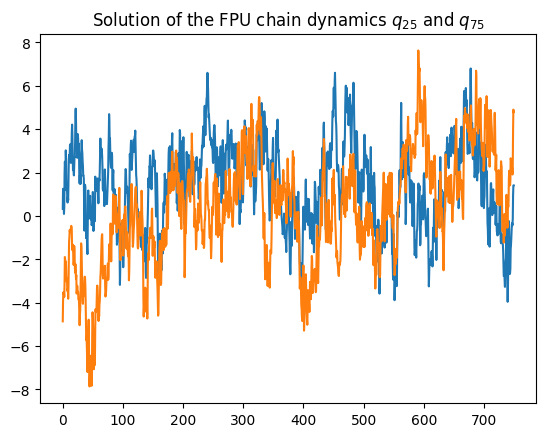

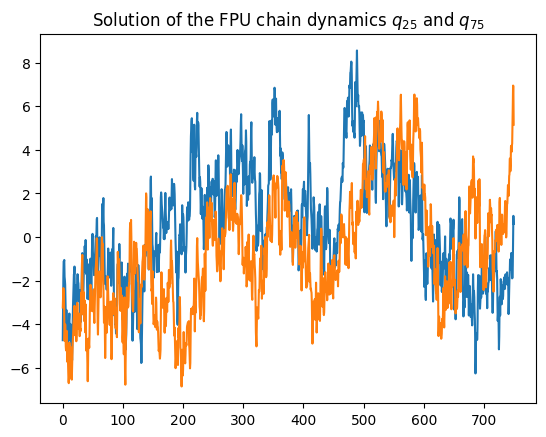

In [9]:
plt.figure(0)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

plt.figure(1)
plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,1])
plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,1])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$ and $q_{75}$")

(400, 400) (400, 400) (400, 400)
(400, 400) (400, 400, 2)


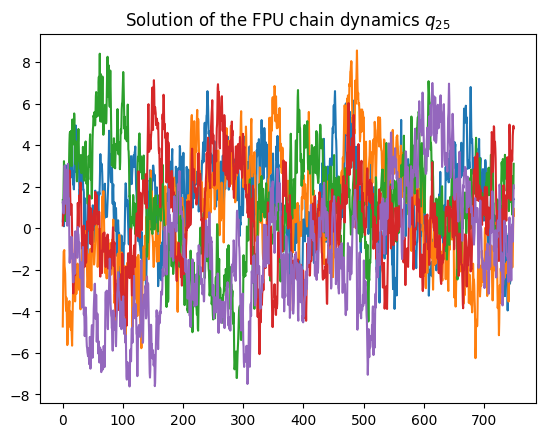

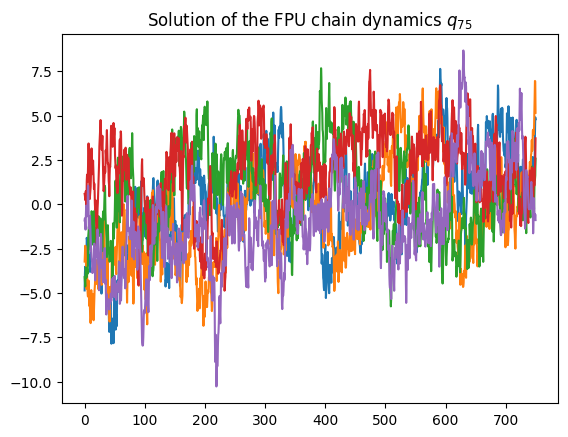

In [10]:
plt.figure(0)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{25}$")

plt.figure(1)
for i in range(5):
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,i])
plt.title(r"Solution of the FPU chain dynamics $q_{75}$")

###########################################   Construct the sample traj for the LSTM learning 
ini=np.random.randn(sec_length,batch)
Traj25 = q25_store[0:sec_length,:]
Traj75 = q75_store[0:sec_length,:]
print(ini.shape, Traj25.shape, Traj75.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj25
Traj[:,:,1] = Traj75
T=np.arange(len(Traj[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(ini.shape, Traj.shape)

In [11]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [12]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical1 = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2 = make_loss('pdf6', target, lower=-5, upper=5, n=N, bw=None, device=device)
loss_pdf_empirical2D = make_loss('pdf2D', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


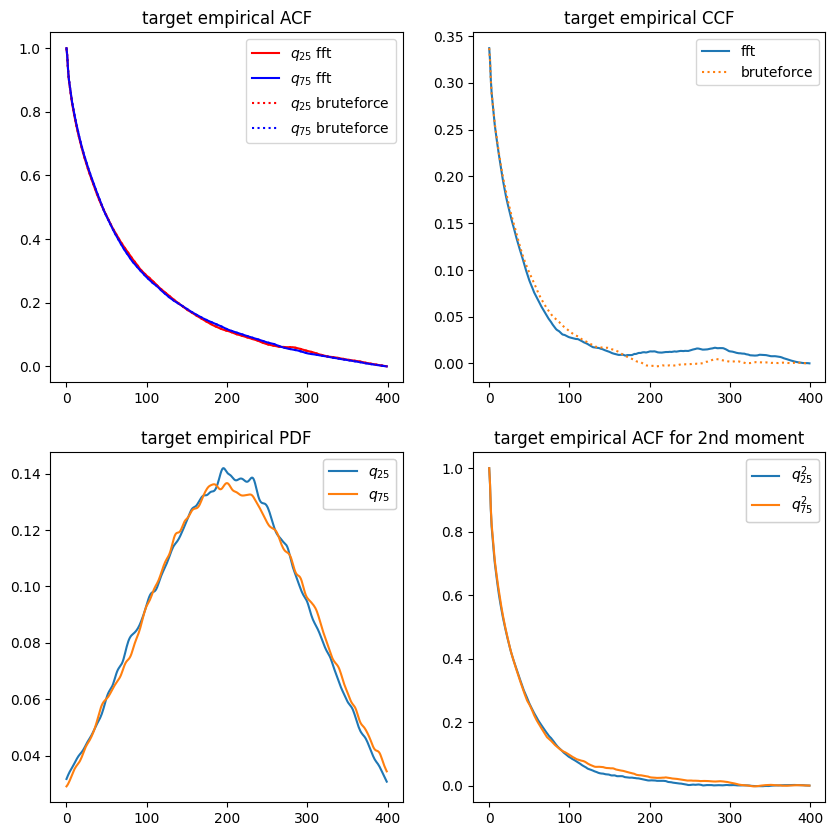

In [13]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_{25}$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,1],'b', label=r'$q_{75}$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_{25}$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_{75}$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical1._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_{25}$',r'$q_{75}$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_{25}^2$',r'$q_{75}^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

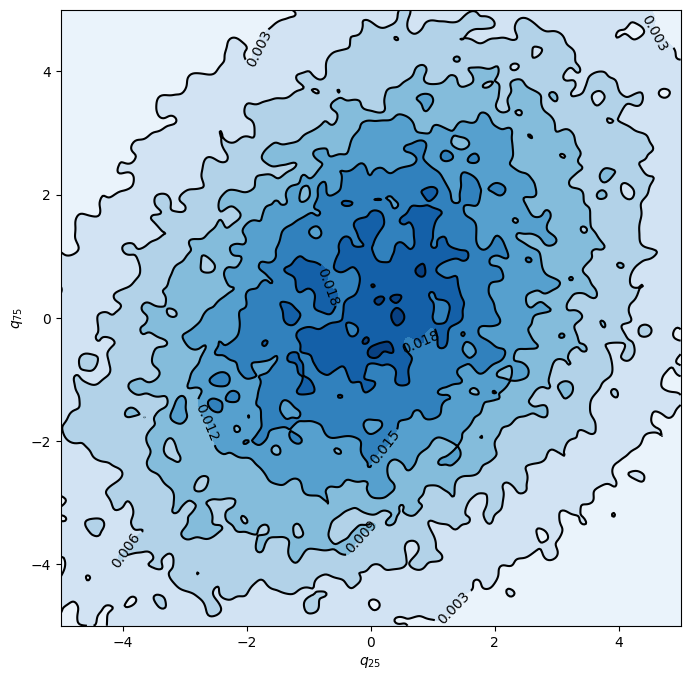

In [14]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5

xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset = ax.contourf(xx, yy, loss_pdf_empirical2D._target.cpu(), cmap='Blues')
## Or kernel density estimate plot instead of the contourf plot

# Contour plot
cset = ax.contour(xx, yy, loss_pdf_empirical2D._target.cpu(), colors='k')
# Label plot
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel(r'$q_{25}$')
ax.set_ylabel(r'$q_{75}$')

plt.show()

Text(0.5, 1.0, 'target empirical PDF')

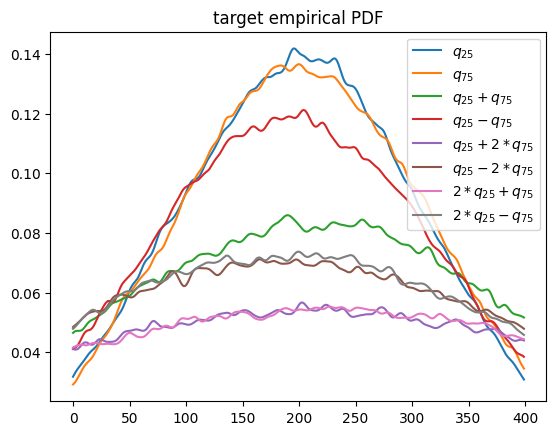

In [15]:
x_grid=-np.linspace(-5,5,num=sec_length)
plt.plot(loss_pdf_empirical1._target.cpu()[...,0],label=r'$q_{25}$')
plt.plot(loss_pdf_empirical1._target.cpu()[...,1],label=r'$q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,0],label=r'$q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,1],label=r'$q_{25}-q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,2],label=r'$q_{25}+2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,3],label=r'$q_{25}-2*q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,4],label=r'$2*q_{25}+q_{75}$')
plt.plot(loss_pdf_empirical2._target.cpu()[...,5],label=r'$2*q_{25}-q_{75}$')
plt.legend()
plt.title('target empirical PDF')

In [16]:
class Model:
    def __init__(self, net):

        self.x_acf_s = None
        self.x_ccf_s = None
        self.x_pdf_s = None
        self.x_pdf2_s = None
        self.x_acf2_s = None
        self.s_collect = []

        self.net = net

        self.T_error=[]
        self.V_error=[]
        self.T_ccf=[]
        self.V_ccf=[]
        self.T_pdf=[]
        self.V_pdf=[]
        self.T_pdf2=[]
        self.V_pdf2=[]
        self.T_acf=[]
        self.V_acf=[]
        self.T_acf2=[]
        self.V_acf2=[]
        self.Step=[]
        self.iter = 0
        self.time = 0

    def train_U(self, x):
        return self.net(x)

    def predict_U(self, x):
        return self.train_U(x)

    def likelihood_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        loss = torch.reciprocal(2. * self.x_acf_s ** 2) * loss_acf.detach()      \
               + torch.reciprocal(2. * self.x_ccf_s ** 2) * loss_ccf.detach()    \
               + torch.reciprocal(2. * self.x_pdf_s ** 2) * loss_pdf.detach()    \
               + torch.reciprocal(2. * self.x_pdf2_s ** 2) * loss_pdf2.detach()  \
               + torch.reciprocal(2. * self.x_acf2_s ** 2) * loss_acf2.detach()  \
               + torch.log(self.x_acf_s * self.x_ccf_s * self.x_pdf_s * self.x_pdf2_s * self.x_acf2_s)
        return loss

    def true_loss(self, loss_acf, loss_ccf, loss_pdf, loss_pdf2, loss_acf2):
        return torch.reciprocal(2. * self.x_acf_s.detach() ** 2) * loss_acf + torch.reciprocal(2. * self.x_ccf_s.detach() ** 2) * loss_ccf + torch.reciprocal(2. * self.x_pdf_s.detach() ** 2) * loss_pdf + torch.reciprocal(2. * self.x_pdf2_s.detach() ** 2) * loss_pdf2 + torch.reciprocal(2. * self.x_acf2_s.detach() ** 2) * loss_acf2

    def run_baseline(self):
        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        for step in range(20000):
            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = loss_acf_fft(prediction)+ loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val)+ loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break

        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')



    def run_AW(self):
        self.x_acf_s = nn.Parameter(self.x_acf_s, requires_grad=True)
        self.x_ccf_s = nn.Parameter(self.x_ccf_s, requires_grad=True)
        self.x_pdf_s = nn.Parameter(self.x_pdf_s, requires_grad=True)
        self.x_pdf2_s = nn.Parameter(self.x_pdf2_s, requires_grad=True)
        self.x_acf2_s = nn.Parameter(self.x_acf2_s, requires_grad=True)


        optimizer_adam = optim.Adam(self.net.parameters(), lr=1e-3)
        optimizer_adam_weight = optim.Adam([self.x_acf_s] + [self.x_ccf_s] + [self.x_pdf_s] + [self.x_pdf2_s] + [self.x_acf2_s],
                                                     lr=1e-3)

        for step in range(20000):
            self.s_collect.append([self.iter, self.x_acf_s.item(), self.x_ccf_s.item(), self.x_pdf_s.item(), self.x_pdf2_s.item(), self.x_acf2_s.item()])

            optimizer_adam.zero_grad()
            ini = np.random.randn(2*sec_length, batch*self.net.lstm.input_size).astype(np.float32) 
            input = torch.from_numpy(ini.reshape(2*sec_length, batch, self.net.lstm.input_size)).to(device)
            prediction, _ = self.train_U(input)
            prediction = prediction[-LAGS:,:,:]
            loss = self.true_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam.step()
            self.iter += 1
            if step % 50 == 0: 
                with torch.no_grad():
                    loss = loss_acf_fft(prediction)+loss_ccf_fft(prediction)+loss_pdf_empirical1(prediction)+loss_pdf_empirical2(prediction)+loss_acf_sec_moment(prediction**2)
                    pred_val, _ = self.predict_U(val_set)
                    pred_val = pred_val[-LAGS:,:,:]
                    loss_val = loss_acf_bruteforce(pred_val)+loss_ccf_bruteforce(pred_val)+ loss_pdf_empirical1(pred_val) + loss_pdf_empirical2(pred_val) + loss_acf_sec_moment(pred_val**2)
                    acf = loss_acf_bruteforce(pred_val)
                    ccf = loss_ccf_bruteforce(pred_val)
                    pdf = loss_pdf_empirical1(pred_val)
                    pdf2 = loss_pdf_empirical2(pred_val)
                    acf_sec_moment = loss_acf_sec_moment(pred_val**2)
                    print('[%d]-th step loss: %.4f, %.4f, acf: %.5f, ccf: %.5f, pdf: %.5f, pdf2: %.5f, acf2: %.5f' % (step, loss, loss_val, acf, ccf, pdf, pdf2, acf_sec_moment))
                    self.T_acf.append(loss_acf_fft(prediction).detach().cpu().numpy())
                    self.V_acf.append(loss_acf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
                    self.V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
                    self.T_pdf.append(loss_pdf_empirical1(prediction).detach().cpu().numpy())
                    self.V_pdf.append(loss_pdf_empirical1(pred_val).detach().cpu().numpy())
                    self.T_pdf2.append(loss_pdf_empirical2(prediction).detach().cpu().numpy())
                    self.V_pdf2.append(loss_pdf_empirical2(pred_val).detach().cpu().numpy())
                    self.T_acf2.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
                    self.V_acf2.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
                    self.T_error.append(loss.detach().cpu().numpy())
                    self.V_error.append(loss_val.detach().cpu().numpy())
                    self.Step.append(step)
            if loss <= 0.0005 and loss_val <= 0.0005:
                break
            optimizer_adam_weight.zero_grad()
            loss = self.likelihood_loss(loss_acf_fft(prediction), loss_ccf_fft(prediction),loss_pdf_empirical1(prediction),loss_pdf_empirical2(prediction),loss_acf_sec_moment(prediction**2))
            loss.backward()
            optimizer_adam_weight.step()
            
        if loss > 0.0005 or loss_val > 0.0005:
            print ('Training failed')
        print('Training finished')


    def train(self):
        self.x_acf_s = torch.tensor(2.).float()
        self.x_ccf_s = torch.tensor(2.).float()
        self.x_pdf_s = torch.tensor(2.).float()
        self.x_pdf2_s = torch.tensor(2.).float()
        self.x_acf2_s = torch.tensor(2.).float()
        start_time = time.time()
        if model_type == 0:
            self.run_baseline()
        elif model_type == 1:
            self.run_AW()
        elapsed = time.time() - start_time
        self.time = elapsed
        print('Training time: %.2f' % elapsed)
        avg_time = elapsed/self.iter
        print('Training time per iteration: %.2f' % avg_time)
        print('Number of Iterations:%d' %self.iter)

In [17]:
model_type = 1

In [18]:
### Defining SINN model
net = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model = Model(net=net)
model.train()

[0]-th step loss: 0.6937, 0.6931, acf: 0.07409, ccf: 0.00444, pdf: 0.29050, pdf2: 0.29617, acf2: 0.02788
[50]-th step loss: 0.1102, 0.1088, acf: 0.03561, ccf: 0.01489, pdf: 0.03276, pdf2: 0.01688, acf2: 0.00864
[100]-th step loss: 0.0373, 0.0413, acf: 0.01837, ccf: 0.00257, pdf: 0.01057, pdf2: 0.00657, acf2: 0.00317
[150]-th step loss: 0.0547, 0.0449, acf: 0.02154, ccf: 0.00259, pdf: 0.01407, pdf2: 0.00404, acf2: 0.00265
[200]-th step loss: 0.0169, 0.0155, acf: 0.00563, ccf: 0.00099, pdf: 0.00403, pdf2: 0.00180, acf2: 0.00302
[250]-th step loss: 0.0107, 0.0122, acf: 0.00516, ccf: 0.00300, pdf: 0.00124, pdf2: 0.00131, acf2: 0.00149
[300]-th step loss: 0.0127, 0.0142, acf: 0.00639, ccf: 0.00460, pdf: 0.00125, pdf2: 0.00088, acf2: 0.00109
[350]-th step loss: 0.0582, 0.0761, acf: 0.00327, ccf: 0.04033, pdf: 0.02527, pdf2: 0.00386, acf2: 0.00332
[400]-th step loss: 0.0149, 0.0147, acf: 0.00795, ccf: 0.00312, pdf: 0.00187, pdf2: 0.00084, acf2: 0.00089
[450]-th step loss: 0.0063, 0.0063, acf:

[3850]-th step loss: 0.0158, 0.0167, acf: 0.00856, ccf: 0.00017, pdf: 0.00612, pdf2: 0.00174, acf2: 0.00013
[3900]-th step loss: 0.0158, 0.0160, acf: 0.00839, ccf: 0.00011, pdf: 0.00563, pdf2: 0.00180, acf2: 0.00009
[3950]-th step loss: 0.0173, 0.0195, acf: 0.01115, ccf: 0.00039, pdf: 0.00605, pdf2: 0.00178, acf2: 0.00009
[4000]-th step loss: 0.0172, 0.0162, acf: 0.00833, ccf: 0.00014, pdf: 0.00597, pdf2: 0.00170, acf2: 0.00007
[4050]-th step loss: 0.0176, 0.0197, acf: 0.01115, ccf: 0.00035, pdf: 0.00634, pdf2: 0.00170, acf2: 0.00014
[4100]-th step loss: 0.0193, 0.0201, acf: 0.01192, ccf: 0.00013, pdf: 0.00612, pdf2: 0.00174, acf2: 0.00016
[4150]-th step loss: 0.0162, 0.0158, acf: 0.00767, ccf: 0.00026, pdf: 0.00605, pdf2: 0.00171, acf2: 0.00011
[4200]-th step loss: 0.0165, 0.0193, acf: 0.01107, ccf: 0.00022, pdf: 0.00617, pdf2: 0.00172, acf2: 0.00011
[4250]-th step loss: 0.0161, 0.0174, acf: 0.00941, ccf: 0.00021, pdf: 0.00595, pdf2: 0.00170, acf2: 0.00010
[4300]-th step loss: 0.0176,

In [19]:
def draw_loss(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot",fontsize=15) 
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'r',label='Training error')
    plt.plot(model.Step, model.V_error,'b--',label='Validation error')
#     plt.loglog(model.Step, model.T_error,'r',label='Training error')
#     plt.loglog(model.Step, model.V_error,'b--',label='Validation error')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)

In [20]:
def draw_errors(model):
    ### Plotting the training and the generalization error
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Error plot for loss functions w/o coeff",fontsize=15)
    plt.yscale('log')
    plt.plot(model.Step, model.T_error,'k',label='Training error')
    plt.plot(model.Step, model.V_error,'k--')
    plt.plot(model.Step, model.T_acf,'r',label='acf error')
    plt.plot(model.Step, model.V_acf,'r--')
    plt.plot(model.Step, model.T_ccf,'b',label='ccf error')
    plt.plot(model.Step, model.V_ccf,'b--')
    plt.plot(model.Step, model.T_pdf,'y',label='pdf error')
    plt.plot(model.Step, model.V_pdf,'y--')
    plt.plot(model.Step, model.T_pdf2,'m',label='pdf2 error')
    plt.plot(model.Step, model.V_pdf2,'m--')
    plt.plot(model.Step, model.T_acf2,'g',label='acf2 error')
    plt.plot(model.Step, model.V_acf2,'g--')
    
#     plt.loglog(model.Step, model.T_error,'k',label='Training error')
#     plt.loglog(model.Step, model.V_error,'k--')
#     plt.loglog(model.Step, model.T_acf,'r',label='acf error')
#     plt.loglog(model.Step, model.V_acf,'r--')
#     plt.loglog(model.Step, model.T_ccf,'b',label='ccf error')
#     plt.loglog(model.Step, model.V_ccf,'b--')
#     plt.loglog(model.Step, model.T_pdf,'y',label='pdf error')
#     plt.loglog(model.Step, model.V_pdf,'y--')
#     plt.loglog(model.Step, model.T_pdf2,'m',label='pdf2 error')
#     plt.loglog(model.Step, model.V_pdf2,'m--')
#     plt.loglog(model.Step, model.T_acf2,'g',label='acf2 error')
#     plt.loglog(model.Step, model.V_acf2,'g--')
    plt.xlabel(r'Training times $n$',fontsize=15)
    plt.ylabel(r'$l_1+l_2$',fontsize=15)
    plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [21]:
def draw_adaptive_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
#     plt.yscale('log')
    plt.plot(s_collect[:, 0], s_collect[:, 1], 'r-', label=r'$\epsilon_{acf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 2], 'b-', label='$\epsilon_{ccf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 3], 'y-', label='$\epsilon_{pdf}$')
    plt.plot(s_collect[:, 0], s_collect[:, 4], 'm-', label='$\epsilon_{pdf2}$')
    plt.plot(s_collect[:, 0], s_collect[:, 5], 'g-', label='$\epsilon_{acf2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$s$')
#     plt.xscale('log')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

In [22]:
def draw_epoch_w(model):
    s_collect = np.array(model.s_collect)
    np.savetxt('s_RAM-AW.npy', s_collect)
    plt.yscale('log')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 1]**2), 'r-', label=r'$\frac{1}{2\epsilon_{acf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 2]**2), 'b-', label=r'$\frac{1}{2\epsilon_{ccf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 3]**2), 'y-', label=r'$\frac{1}{2\epsilon_{pdf}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 4]**2), 'm-', label=r'$\frac{1}{2\epsilon_{pdf2}^2}$')
    plt.plot(s_collect[:, 0], np.reciprocal(2. * s_collect[:, 5]**2), 'g-', label=r'$\frac{1}{2\epsilon_{acf2}^2}$')
    plt.xlabel('$Iters$')
    plt.ylabel('$\omega$')
    plt.legend()
#     plt.savefig('2dpossion_S_RAM-AW.pdf')
    plt.show()

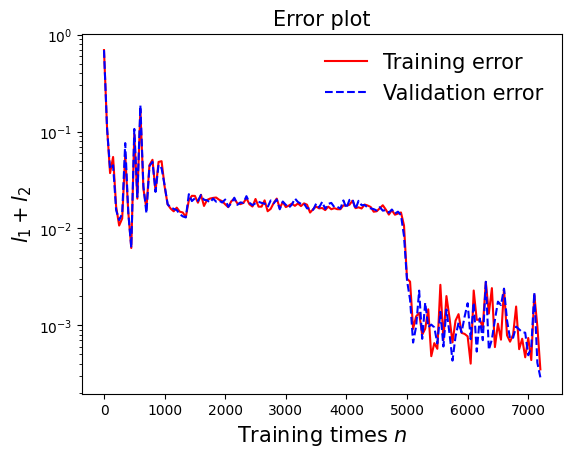

In [23]:
draw_loss(model)

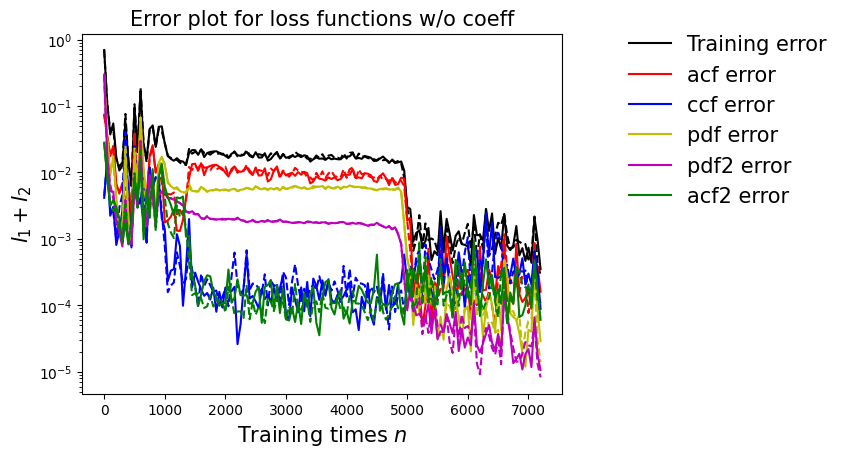

In [24]:
draw_errors(model)

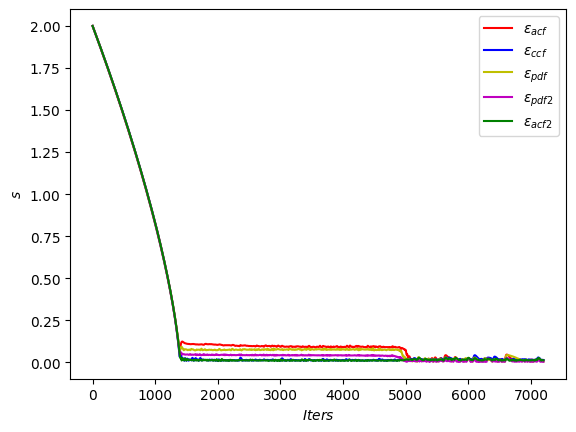

In [25]:
draw_adaptive_w(model)

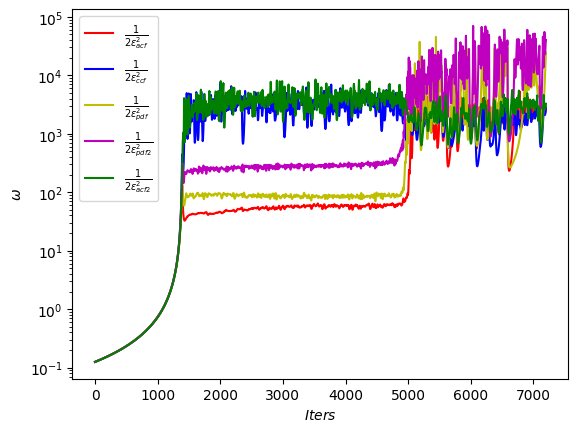

In [26]:
draw_epoch_w(model)

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [27]:
def test1(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$ and $q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [28]:
def test2(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
    acf_t=StatLoss.acf(target)
    corr_p1=acf_p.detach().cpu().numpy()
    corr_t1=acf_t.detach().cpu().numpy()
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p2=ccf_p.detach().cpu().numpy()
    corr_t2=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_1$',fontsize=15)    
    plt.plot(T, corr_t1[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $\tilde{q}_2$',fontsize=15)          
    plt.plot(T, corr_t1[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p1[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t2[:,:],'r')        # correlation function of the target 
    plt.plot(T, corr_p2[:,:], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
#     plt.ylim(-0.05,0.05)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [29]:
def test3(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 400, None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    rho_data2 =  StatLoss.gauss_kde6(target, -5, 5, 400, None).cpu()
    rho_prediction2 = StatLoss.gauss_kde6(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()


    x=np.linspace(-5, 5, 400)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_{25}$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_{25}$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,0],label=r'Exact PDF of $q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,1],label=r'Exact PDF of $q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,0], ':',label=r'PDF of the output $q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,1], ':',label=r'PDF of the output $q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,2],label=r'Exact PDF of $q_{25}+2q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,3],label=r'Exact PDF of $q_{25}-2q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,2], ':',label=r'PDF of the output $q_{25}+2q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,3], ':',label=r'PDF of the output $q_{25}-2q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    fig = plt.figure(3)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function of sum and diff",fontsize=15)    
    plt.plot(x, rho_data2.numpy()[...,4],label=r'Exact PDF of $2q_{25}+q_{75}$')    # target PDF
    plt.plot(x, rho_data2.numpy()[...,5],label=r'Exact PDF of $2q_{25}-q_{75}$')    # target PDF
#     plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction2.numpy()[...,4], ':',label=r'PDF of the output $2q_{25}+q_{75}$')  # PDF after the training 
    plt.plot(x, rho_prediction2.numpy()[...,5], ':',label=r'PDF of the output $2q_{25}-q_{75}$')  # PDF after the training 
    plt.xlim(-5,5)
#     plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 4: Comparing the higher-order ACF

In [30]:
def test4(model):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{25}^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_{75}^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [31]:
def test5(model):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= model.predict_U(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q25_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{25}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q75_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

## Test 6: comparing scatter plots

In [32]:
def test6(model):
    # Test 6: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.scatter(Traj[:,:,0], Traj[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.scatter(prediction[:,:,0],prediction[:,:,1])
    plt.xlabel(r'$q_{25}(t)$',fontsize=15)
    plt.ylabel(r'$q_{75}(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

## Test 7: comparing joint PDF contours

In [33]:
def test7(model):
    # Test 5: scatter plot of SINN
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= model.predict_U(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    rho_data =  StatLoss.gauss_kde2D(target, -5, 5, 400, None).cpu()
    rho_prediction = StatLoss.gauss_kde2D(Pred[-sec_length:,:,:].detach(), -5, 5, 400,None).cpu()
    
    fig = plt.figure(0, figsize=(5, 5))
    plt.title("PDF Contours",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

    xx, yy = np.mgrid[xmin:xmax:400j, ymin:ymax:400j]
    axs[0]  = fig.gca()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.contour(xx,yy,rho_data.numpy(),colors='r')
    plt.contour(xx,yy,rho_prediction.numpy(),colors='b',linestyles='dashed')

    plt.xlabel(r'$q_{25}$')
    plt.ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(1,figsize=(5, 5))
    plt.title("MD trajectories",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_data.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_data.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

    
    
    fig = plt.figure(2,figsize=(5, 5))
    plt.title("SINN output",fontsize=15) 
    xmin, xmax = -5, 5
    ymin, ymax = -5, 5

#     xx, yy = np.mgrid[xmin:xmax:20j, ymin:ymax:20j]
    ax  = fig.gca()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    cfset = ax.contourf(xx, yy, rho_prediction.numpy(), cmap='Blues')
    cset = ax.contour(xx, yy, rho_prediction.numpy(), colors='k')

    ax.clabel(cset, inline=1, fontsize=10)
    ax.set_xlabel(r'$q_{25}$')
    ax.set_ylabel(r'$q_{75}$')

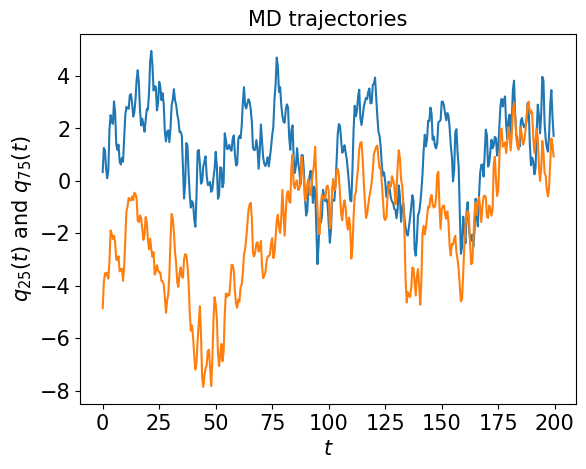

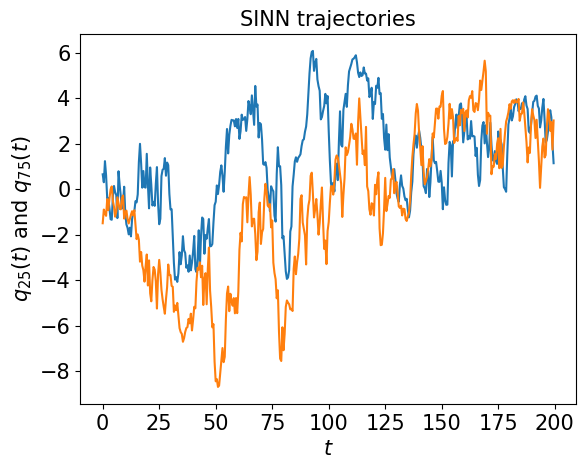

In [34]:
test1(model)

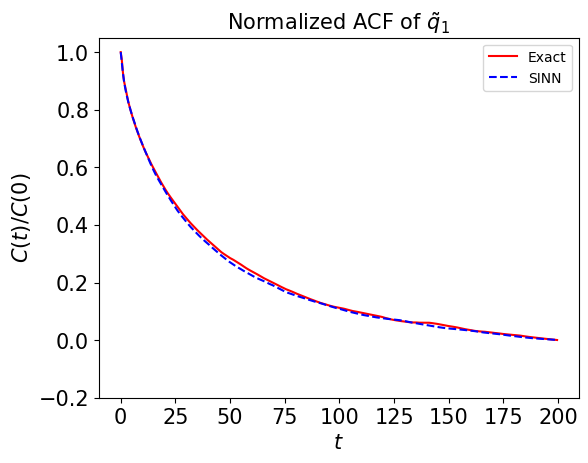

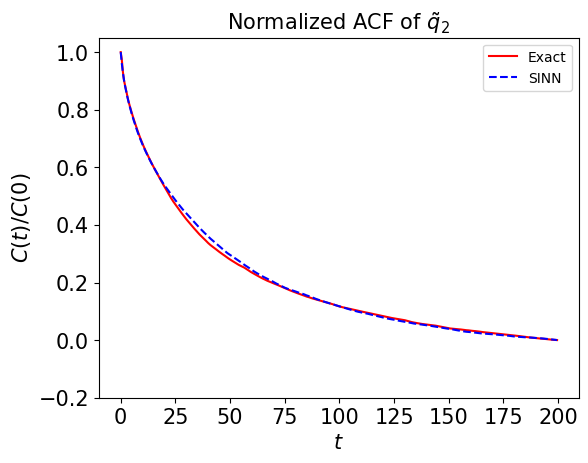

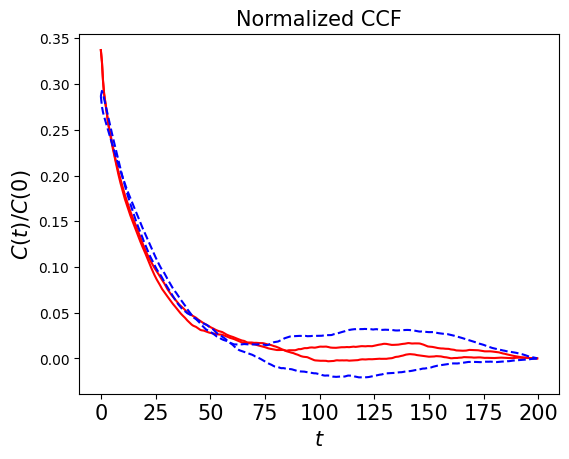

In [35]:
test2(model)

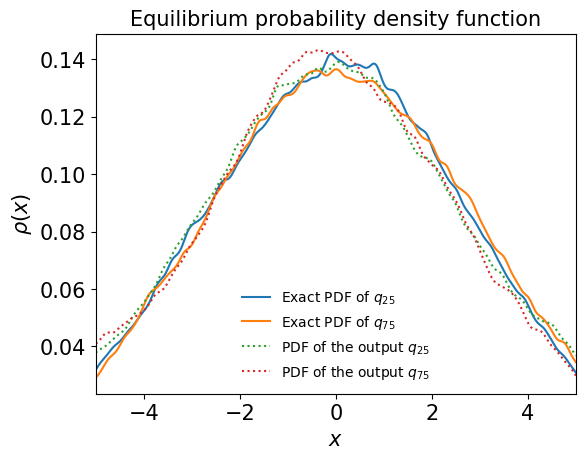

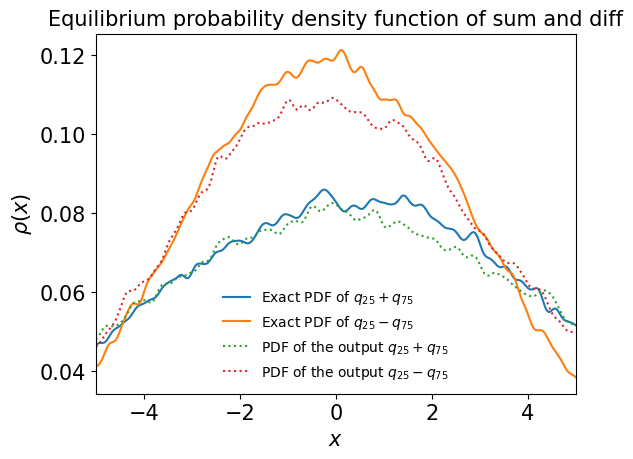

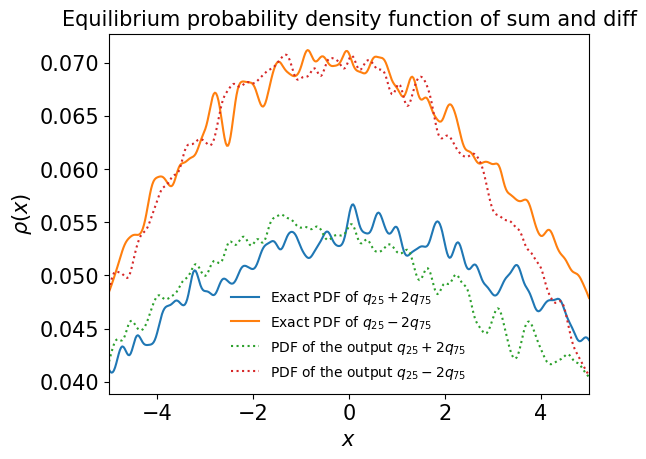

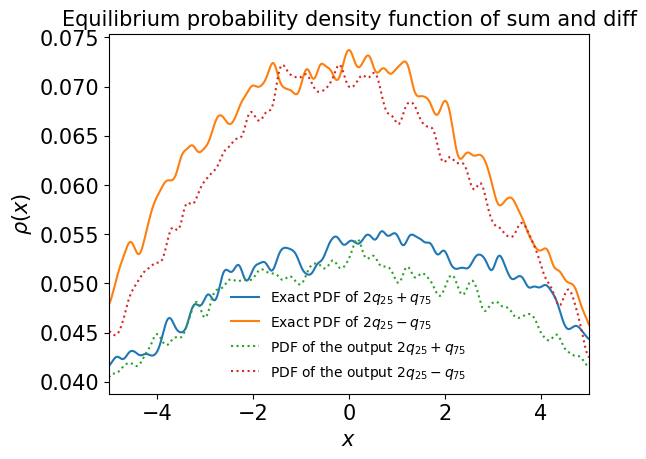

In [36]:
test3(model)

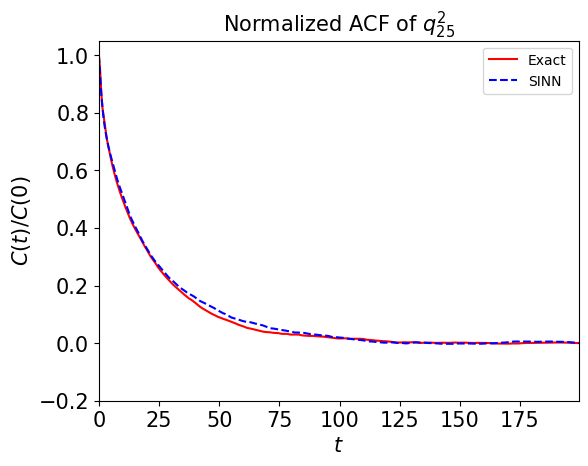

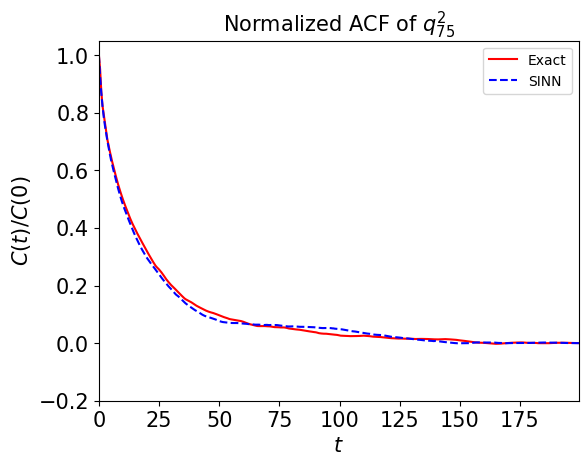

In [37]:
test4(model)

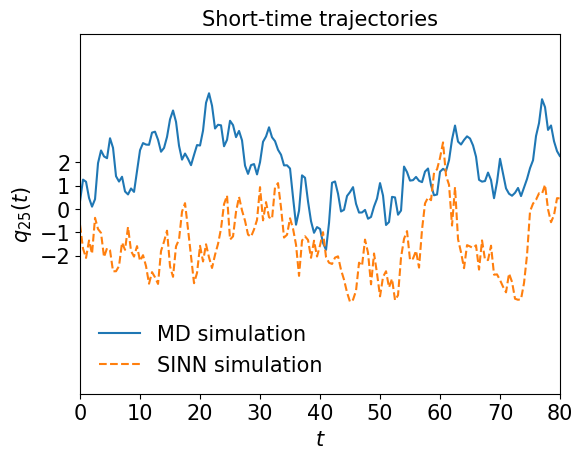

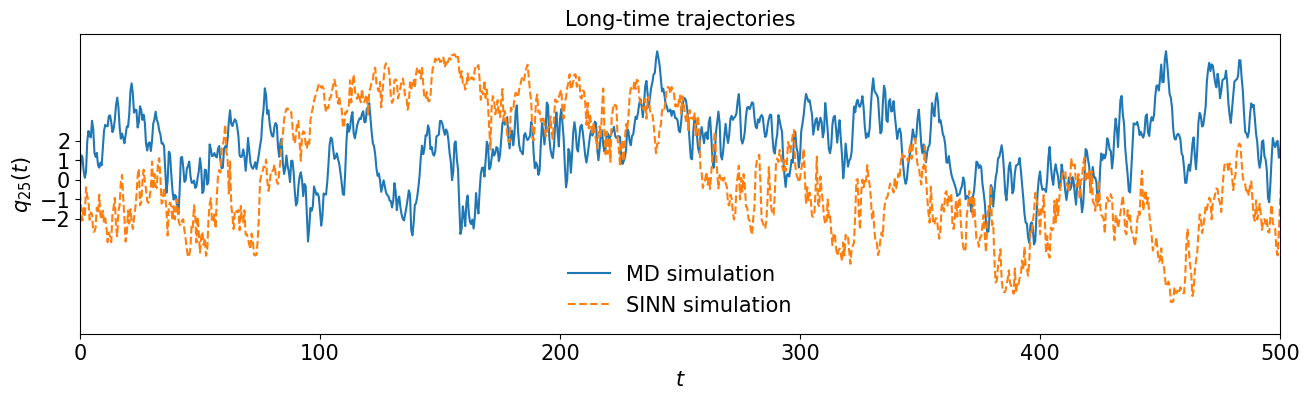

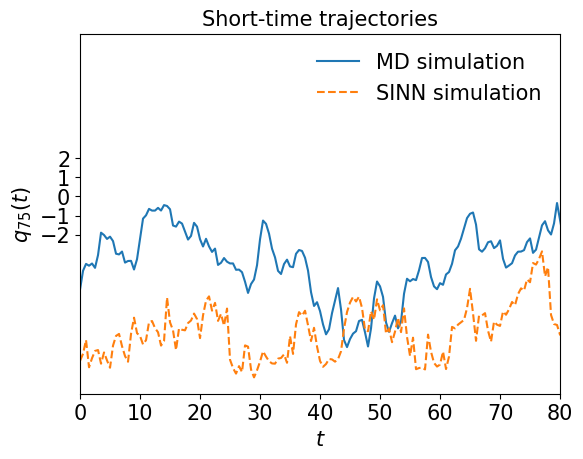

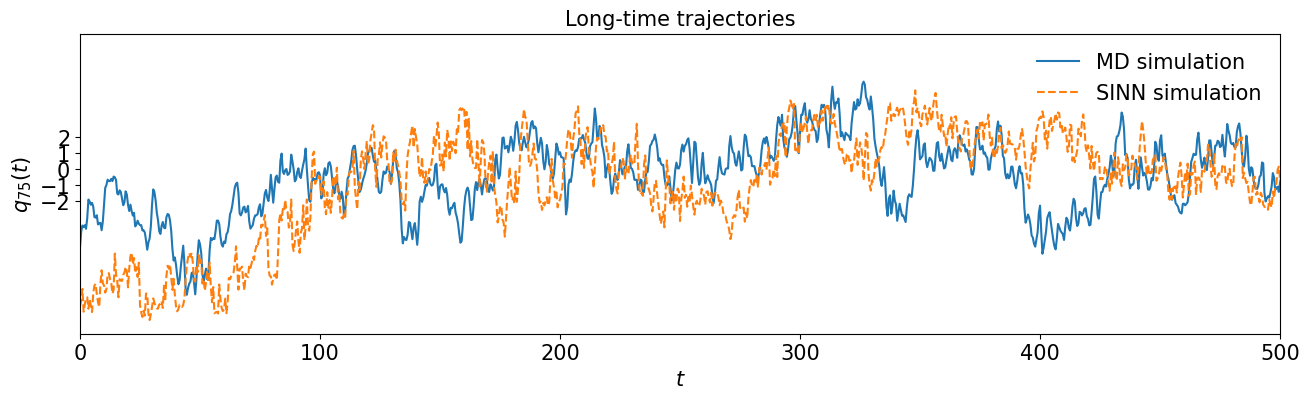

In [38]:
test5(model)

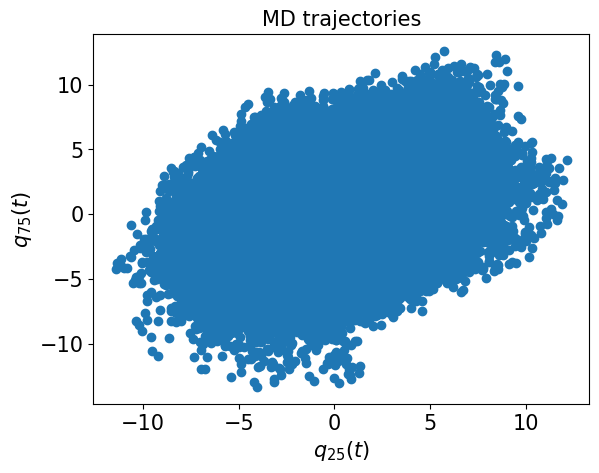

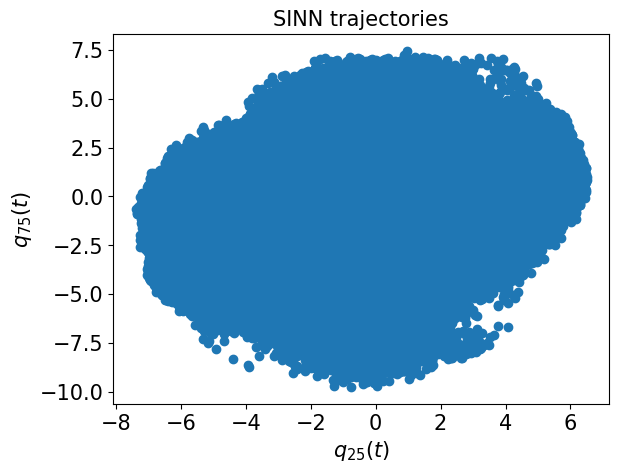

In [39]:
test6(model)

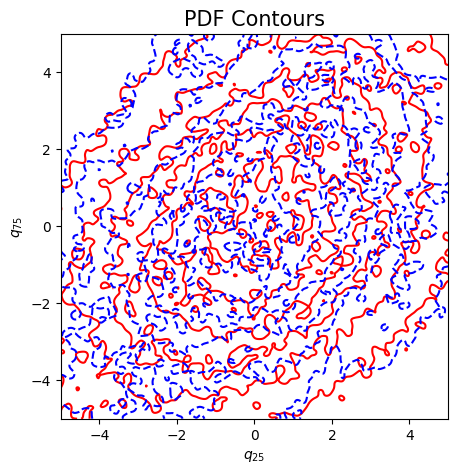

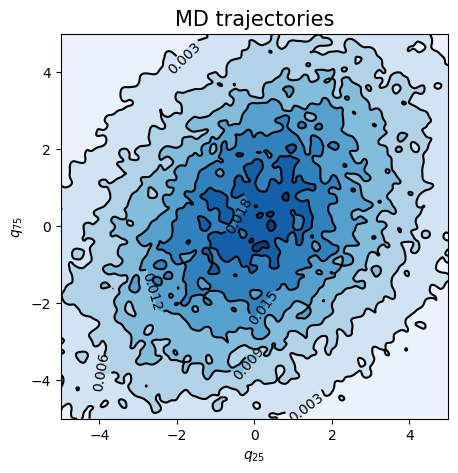

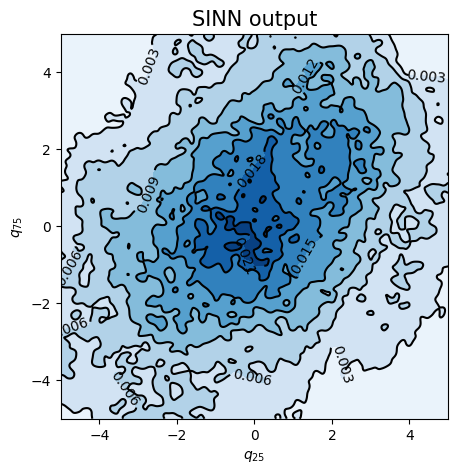

In [40]:
test7(model)

In [41]:
### Defining SINN model
net1 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model1 = Model(net=net1)
model1.train()

[0]-th step loss: 0.7012, 0.6943, acf: 0.07577, ccf: 0.00602, pdf: 0.28978, pdf2: 0.29334, acf2: 0.02938
[50]-th step loss: 0.0812, 0.0785, acf: 0.01794, ccf: 0.02253, pdf: 0.02353, pdf2: 0.01279, acf2: 0.00169
[100]-th step loss: 0.0562, 0.0546, acf: 0.02073, ccf: 0.01559, pdf: 0.00973, pdf2: 0.00582, acf2: 0.00275
[150]-th step loss: 0.1659, 0.0834, acf: 0.00429, ccf: 0.01233, pdf: 0.04942, pdf2: 0.01151, acf2: 0.00580
[200]-th step loss: 0.0257, 0.0270, acf: 0.00651, ccf: 0.00675, pdf: 0.00713, pdf2: 0.00325, acf2: 0.00332
[250]-th step loss: 0.1133, 0.1151, acf: 0.05594, ccf: 0.00385, pdf: 0.02354, pdf2: 0.01518, acf2: 0.01661
[300]-th step loss: 0.0495, 0.0518, acf: 0.01804, ccf: 0.00892, pdf: 0.01338, pdf2: 0.00846, acf2: 0.00296
[350]-th step loss: 0.0341, 0.0325, acf: 0.01604, ccf: 0.00394, pdf: 0.00645, pdf2: 0.00511, acf2: 0.00100
[400]-th step loss: 0.0196, 0.0204, acf: 0.01166, ccf: 0.00193, pdf: 0.00390, pdf2: 0.00192, acf2: 0.00102
[450]-th step loss: 0.1383, 0.1411, acf:

[3850]-th step loss: 0.0214, 0.0183, acf: 0.01091, ccf: 0.00049, pdf: 0.00497, pdf2: 0.00165, acf2: 0.00026
[3900]-th step loss: 0.0204, 0.0215, acf: 0.01413, ccf: 0.00048, pdf: 0.00515, pdf2: 0.00158, acf2: 0.00012
[3950]-th step loss: 0.0235, 0.0229, acf: 0.01539, ccf: 0.00054, pdf: 0.00521, pdf2: 0.00157, acf2: 0.00019
[4000]-th step loss: 0.0194, 0.0200, acf: 0.01325, ccf: 0.00014, pdf: 0.00491, pdf2: 0.00157, acf2: 0.00010
[4050]-th step loss: 0.0217, 0.0205, acf: 0.01371, ccf: 0.00020, pdf: 0.00483, pdf2: 0.00161, acf2: 0.00012
[4100]-th step loss: 0.0220, 0.0196, acf: 0.01299, ccf: 0.00013, pdf: 0.00488, pdf2: 0.00156, acf2: 0.00009
[4150]-th step loss: 0.0215, 0.0201, acf: 0.01325, ccf: 0.00031, pdf: 0.00482, pdf2: 0.00161, acf2: 0.00015
[4200]-th step loss: 0.0215, 0.0180, acf: 0.01121, ccf: 0.00027, pdf: 0.00466, pdf2: 0.00159, acf2: 0.00026
[4250]-th step loss: 0.0223, 0.0197, acf: 0.01332, ccf: 0.00017, pdf: 0.00440, pdf2: 0.00167, acf2: 0.00013
[4300]-th step loss: 0.0220,

[7650]-th step loss: 0.0535, 0.0547, acf: 0.03597, ccf: 0.00010, pdf: 0.00733, pdf2: 0.00442, acf2: 0.00686
[7700]-th step loss: 0.0475, 0.0527, acf: 0.03524, ccf: 0.00011, pdf: 0.00693, pdf2: 0.00435, acf2: 0.00605
[7750]-th step loss: 0.0434, 0.0444, acf: 0.02890, ccf: 0.00010, pdf: 0.00746, pdf2: 0.00438, acf2: 0.00354
[7800]-th step loss: 0.0357, 0.0356, acf: 0.02201, ccf: 0.00010, pdf: 0.00812, pdf2: 0.00431, acf2: 0.00101
[7850]-th step loss: 0.0326, 0.0368, acf: 0.02478, ccf: 0.00014, pdf: 0.00657, pdf2: 0.00409, acf2: 0.00125
[7900]-th step loss: 0.0267, 0.0286, acf: 0.01784, ccf: 0.00011, pdf: 0.00618, pdf2: 0.00402, acf2: 0.00048
[7950]-th step loss: 0.0264, 0.0290, acf: 0.01792, ccf: 0.00022, pdf: 0.00654, pdf2: 0.00412, acf2: 0.00019
[8000]-th step loss: 0.0268, 0.0296, acf: 0.01890, ccf: 0.00023, pdf: 0.00604, pdf2: 0.00396, acf2: 0.00043
[8050]-th step loss: 0.0235, 0.0231, acf: 0.01259, ccf: 0.00018, pdf: 0.00626, pdf2: 0.00392, acf2: 0.00011
[8100]-th step loss: 0.0240,

[11450]-th step loss: 0.0201, 0.0212, acf: 0.01381, ccf: 0.00017, pdf: 0.00506, pdf2: 0.00207, acf2: 0.00010
[11500]-th step loss: 0.0178, 0.0187, acf: 0.01120, ccf: 0.00009, pdf: 0.00543, pdf2: 0.00188, acf2: 0.00008
[11550]-th step loss: 0.0172, 0.0194, acf: 0.01197, ccf: 0.00008, pdf: 0.00531, pdf2: 0.00186, acf2: 0.00014
[11600]-th step loss: 0.0184, 0.0191, acf: 0.01153, ccf: 0.00011, pdf: 0.00552, pdf2: 0.00183, acf2: 0.00009
[11650]-th step loss: 0.0196, 0.0209, acf: 0.01362, ccf: 0.00013, pdf: 0.00510, pdf2: 0.00196, acf2: 0.00008
[11700]-th step loss: 0.0198, 0.0196, acf: 0.01193, ccf: 0.00019, pdf: 0.00555, pdf2: 0.00184, acf2: 0.00007
[11750]-th step loss: 0.0210, 0.0213, acf: 0.01357, ccf: 0.00040, pdf: 0.00533, pdf2: 0.00183, acf2: 0.00014
[11800]-th step loss: 0.0217, 0.0204, acf: 0.01301, ccf: 0.00017, pdf: 0.00534, pdf2: 0.00182, acf2: 0.00008
[11850]-th step loss: 0.0199, 0.0197, acf: 0.01226, ccf: 0.00013, pdf: 0.00542, pdf2: 0.00184, acf2: 0.00006
[11900]-th step los

[15250]-th step loss: 0.0210, 0.0201, acf: 0.01174, ccf: 0.00006, pdf: 0.00616, pdf2: 0.00188, acf2: 0.00023
[15300]-th step loss: 0.0196, 0.0179, acf: 0.01034, ccf: 0.00013, pdf: 0.00559, pdf2: 0.00174, acf2: 0.00005
[15350]-th step loss: 0.0196, 0.0194, acf: 0.01148, ccf: 0.00019, pdf: 0.00599, pdf2: 0.00169, acf2: 0.00008
[15400]-th step loss: 0.0181, 0.0197, acf: 0.01140, ccf: 0.00049, pdf: 0.00605, pdf2: 0.00172, acf2: 0.00008
[15450]-th step loss: 0.0192, 0.0173, acf: 0.00982, ccf: 0.00010, pdf: 0.00565, pdf2: 0.00171, acf2: 0.00006
[15500]-th step loss: 0.0192, 0.0190, acf: 0.01120, ccf: 0.00028, pdf: 0.00576, pdf2: 0.00168, acf2: 0.00009
[15550]-th step loss: 0.0164, 0.0178, acf: 0.01024, ccf: 0.00013, pdf: 0.00570, pdf2: 0.00166, acf2: 0.00007
[15600]-th step loss: 0.0168, 0.0182, acf: 0.01077, ccf: 0.00011, pdf: 0.00558, pdf2: 0.00169, acf2: 0.00007
[15650]-th step loss: 0.0164, 0.0198, acf: 0.01160, ccf: 0.00016, pdf: 0.00621, pdf2: 0.00160, acf2: 0.00025
[15700]-th step los

[19050]-th step loss: 0.0174, 0.0171, acf: 0.00961, ccf: 0.00018, pdf: 0.00539, pdf2: 0.00178, acf2: 0.00014
[19100]-th step loss: 0.0164, 0.0166, acf: 0.00895, ccf: 0.00035, pdf: 0.00551, pdf2: 0.00170, acf2: 0.00009
[19150]-th step loss: 0.0156, 0.0167, acf: 0.00926, ccf: 0.00007, pdf: 0.00561, pdf2: 0.00164, acf2: 0.00007
[19200]-th step loss: 0.0164, 0.0166, acf: 0.00935, ccf: 0.00007, pdf: 0.00551, pdf2: 0.00166, acf2: 0.00005
[19250]-th step loss: 0.0165, 0.0167, acf: 0.00914, ccf: 0.00011, pdf: 0.00563, pdf2: 0.00174, acf2: 0.00008
[19300]-th step loss: 0.0167, 0.0177, acf: 0.01017, ccf: 0.00015, pdf: 0.00563, pdf2: 0.00164, acf2: 0.00009
[19350]-th step loss: 0.0166, 0.0171, acf: 0.00927, ccf: 0.00022, pdf: 0.00587, pdf2: 0.00160, acf2: 0.00010
[19400]-th step loss: 0.0159, 0.0171, acf: 0.00944, ccf: 0.00020, pdf: 0.00575, pdf2: 0.00162, acf2: 0.00006
[19450]-th step loss: 0.0160, 0.0162, acf: 0.00888, ccf: 0.00009, pdf: 0.00555, pdf2: 0.00164, acf2: 0.00003
[19500]-th step los

In [42]:
### Defining SINN model
net2 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model2 = Model(net=net2)
model2.train()

[0]-th step loss: 0.6962, 0.6929, acf: 0.07329, ccf: 0.00390, pdf: 0.29082, pdf2: 0.29745, acf2: 0.02743
[50]-th step loss: 0.1158, 0.1108, acf: 0.03717, ccf: 0.01445, pdf: 0.03315, pdf2: 0.01781, acf2: 0.00821
[100]-th step loss: 0.0758, 0.0742, acf: 0.01208, ccf: 0.02049, pdf: 0.02612, pdf2: 0.01388, acf2: 0.00158
[150]-th step loss: 0.0451, 0.0417, acf: 0.01077, ccf: 0.01046, pdf: 0.01369, pdf2: 0.00557, acf2: 0.00118
[200]-th step loss: 0.0885, 0.0888, acf: 0.04019, ccf: 0.01360, pdf: 0.01425, pdf2: 0.01233, acf2: 0.00842
[250]-th step loss: 0.0492, 0.0542, acf: 0.02049, ccf: 0.01309, pdf: 0.00777, pdf2: 0.00355, acf2: 0.00926
[300]-th step loss: 0.0492, 0.0452, acf: 0.00662, ccf: 0.02865, pdf: 0.00460, pdf2: 0.00288, acf2: 0.00248
[350]-th step loss: 0.0536, 0.0488, acf: 0.00727, ccf: 0.02739, pdf: 0.00925, pdf2: 0.00349, acf2: 0.00145
[400]-th step loss: 0.0455, 0.0468, acf: 0.00571, ccf: 0.02788, pdf: 0.00741, pdf2: 0.00360, acf2: 0.00223
[450]-th step loss: 0.0262, 0.0275, acf:

[3850]-th step loss: 0.0016, 0.0012, acf: 0.00090, ccf: 0.00018, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00012
[3900]-th step loss: 0.0014, 0.0007, acf: 0.00032, ccf: 0.00018, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00012
[3950]-th step loss: 0.0010, 0.0007, acf: 0.00038, ccf: 0.00020, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00011
[4000]-th step loss: 0.0014, 0.0008, acf: 0.00028, ccf: 0.00039, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00008
[4050]-th step loss: 0.0007, 0.0008, acf: 0.00015, ccf: 0.00039, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00019
[4100]-th step loss: 0.0008, 0.0007, acf: 0.00014, ccf: 0.00037, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00013
[4150]-th step loss: 0.0008, 0.0003, acf: 0.00005, ccf: 0.00013, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00011
[4200]-th step loss: 0.0033, 0.0050, acf: 0.00120, ccf: 0.00141, pdf: 0.00041, pdf2: 0.00011, acf2: 0.00187
[4250]-th step loss: 0.0014, 0.0009, acf: 0.00019, ccf: 0.00016, pdf: 0.00010, pdf2: 0.00004, acf2: 0.00036
[4300]-th step loss: 0.0017,

In [43]:
### Defining SINN model
net3 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model3 = Model(net=net3)
model3.train()

[0]-th step loss: 0.7083, 0.7048, acf: 0.07499, ccf: 0.01507, pdf: 0.29038, pdf2: 0.29559, acf2: 0.02872
[50]-th step loss: 0.1149, 0.1172, acf: 0.03260, ccf: 0.01845, pdf: 0.03515, pdf2: 0.02151, acf2: 0.00947
[100]-th step loss: 0.0498, 0.0478, acf: 0.01717, ccf: 0.00877, pdf: 0.01537, pdf2: 0.00427, acf2: 0.00219
[150]-th step loss: 0.0262, 0.0403, acf: 0.00894, ccf: 0.01373, pdf: 0.01323, pdf2: 0.00385, acf2: 0.00050
[200]-th step loss: 0.0185, 0.0219, acf: 0.01024, ccf: 0.00097, pdf: 0.00700, pdf2: 0.00259, acf2: 0.00106
[250]-th step loss: 0.0158, 0.0139, acf: 0.00652, ccf: 0.00234, pdf: 0.00251, pdf2: 0.00181, acf2: 0.00068
[300]-th step loss: 0.0397, 0.0407, acf: 0.00426, ccf: 0.01716, pdf: 0.01472, pdf2: 0.00291, acf2: 0.00167
[350]-th step loss: 0.0084, 0.0068, acf: 0.00210, ccf: 0.00164, pdf: 0.00136, pdf2: 0.00091, acf2: 0.00079
[400]-th step loss: 0.0056, 0.0044, acf: 0.00199, ccf: 0.00030, pdf: 0.00099, pdf2: 0.00053, acf2: 0.00063
[450]-th step loss: 0.0065, 0.0066, acf:

[3850]-th step loss: 0.0123, 0.0143, acf: 0.01322, ccf: 0.00063, pdf: 0.00017, pdf2: 0.00004, acf2: 0.00029
[3900]-th step loss: 0.0095, 0.0105, acf: 0.00919, ccf: 0.00033, pdf: 0.00043, pdf2: 0.00012, acf2: 0.00042
[3950]-th step loss: 0.0098, 0.0099, acf: 0.00873, ccf: 0.00040, pdf: 0.00028, pdf2: 0.00008, acf2: 0.00037
[4000]-th step loss: 0.0083, 0.0090, acf: 0.00815, ccf: 0.00025, pdf: 0.00020, pdf2: 0.00005, acf2: 0.00037
[4050]-th step loss: 0.0200, 0.0182, acf: 0.01451, ccf: 0.00105, pdf: 0.00062, pdf2: 0.00022, acf2: 0.00182
[4100]-th step loss: 0.0119, 0.0138, acf: 0.01235, ccf: 0.00043, pdf: 0.00015, pdf2: 0.00005, acf2: 0.00080
[4150]-th step loss: 0.0111, 0.0129, acf: 0.01179, ccf: 0.00042, pdf: 0.00009, pdf2: 0.00003, acf2: 0.00055
[4200]-th step loss: 0.0518, 0.0510, acf: 0.03406, ccf: 0.00325, pdf: 0.00307, pdf2: 0.00095, acf2: 0.00968
[4250]-th step loss: 0.0301, 0.0330, acf: 0.02339, ccf: 0.00323, pdf: 0.00166, pdf2: 0.00100, acf2: 0.00376
[4300]-th step loss: 0.0295,

[7650]-th step loss: 0.0232, 0.0381, acf: 0.01876, ccf: 0.00331, pdf: 0.00766, pdf2: 0.00313, acf2: 0.00529
[7700]-th step loss: 0.0193, 0.0194, acf: 0.01122, ccf: 0.00014, pdf: 0.00557, pdf2: 0.00188, acf2: 0.00063
[7750]-th step loss: 0.0140, 0.0200, acf: 0.01095, ccf: 0.00066, pdf: 0.00577, pdf2: 0.00203, acf2: 0.00060
[7800]-th step loss: 0.0191, 0.0172, acf: 0.00951, ccf: 0.00009, pdf: 0.00554, pdf2: 0.00182, acf2: 0.00021
[7850]-th step loss: 0.0186, 0.0217, acf: 0.01279, ccf: 0.00067, pdf: 0.00582, pdf2: 0.00188, acf2: 0.00050
[7900]-th step loss: 0.0627, 0.0664, acf: 0.05382, ccf: 0.00142, pdf: 0.00618, pdf2: 0.00230, acf2: 0.00264
[7950]-th step loss: 0.0438, 0.0438, acf: 0.03704, ccf: 0.00116, pdf: 0.00395, pdf2: 0.00125, acf2: 0.00037
[8000]-th step loss: 0.0342, 0.0341, acf: 0.02917, ccf: 0.00133, pdf: 0.00222, pdf2: 0.00063, acf2: 0.00078
[8050]-th step loss: 0.0311, 0.0323, acf: 0.02624, ccf: 0.00178, pdf: 0.00308, pdf2: 0.00083, acf2: 0.00034
[8100]-th step loss: 0.0309,

[11450]-th step loss: 0.0050, 0.0043, acf: 0.00336, ccf: 0.00036, pdf: 0.00020, pdf2: 0.00008, acf2: 0.00035
[11500]-th step loss: 0.0063, 0.0048, acf: 0.00367, ccf: 0.00040, pdf: 0.00006, pdf2: 0.00005, acf2: 0.00057
[11550]-th step loss: 0.0083, 0.0065, acf: 0.00377, ccf: 0.00056, pdf: 0.00021, pdf2: 0.00005, acf2: 0.00195
[11600]-th step loss: 0.0099, 0.0076, acf: 0.00271, ccf: 0.00098, pdf: 0.00052, pdf2: 0.00026, acf2: 0.00317
[11650]-th step loss: 0.0086, 0.0067, acf: 0.00561, ccf: 0.00042, pdf: 0.00010, pdf2: 0.00008, acf2: 0.00052
[11700]-th step loss: 0.0076, 0.0058, acf: 0.00446, ccf: 0.00025, pdf: 0.00026, pdf2: 0.00020, acf2: 0.00067
[11750]-th step loss: 0.0080, 0.0061, acf: 0.00503, ccf: 0.00015, pdf: 0.00013, pdf2: 0.00008, acf2: 0.00067
[11800]-th step loss: 0.0063, 0.0067, acf: 0.00593, ccf: 0.00019, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00052
[11850]-th step loss: 0.0185, 0.0184, acf: 0.01408, ccf: 0.00070, pdf: 0.00100, pdf2: 0.00031, acf2: 0.00227
[11900]-th step los

[15250]-th step loss: 0.0355, 0.0353, acf: 0.02610, ccf: 0.00017, pdf: 0.00466, pdf2: 0.00284, acf2: 0.00156
[15300]-th step loss: 0.0404, 0.0424, acf: 0.03317, ccf: 0.00012, pdf: 0.00445, pdf2: 0.00268, acf2: 0.00195
[15350]-th step loss: 0.0299, 0.0348, acf: 0.02749, ccf: 0.00012, pdf: 0.00431, pdf2: 0.00253, acf2: 0.00038
[15400]-th step loss: 0.0315, 0.0344, acf: 0.02716, ccf: 0.00022, pdf: 0.00417, pdf2: 0.00235, acf2: 0.00051
[15450]-th step loss: 0.0302, 0.0269, acf: 0.01992, ccf: 0.00019, pdf: 0.00429, pdf2: 0.00228, acf2: 0.00021
[15500]-th step loss: 0.0677, 0.0746, acf: 0.04596, ccf: 0.00123, pdf: 0.00932, pdf2: 0.00598, acf2: 0.01209
[15550]-th step loss: 0.0480, 0.0544, acf: 0.03328, ccf: 0.00043, pdf: 0.00925, pdf2: 0.00457, acf2: 0.00685
[15600]-th step loss: 0.0456, 0.0449, acf: 0.02658, ccf: 0.00021, pdf: 0.00924, pdf2: 0.00441, acf2: 0.00442
[15650]-th step loss: 0.0424, 0.0426, acf: 0.02530, ccf: 0.00012, pdf: 0.00921, pdf2: 0.00405, acf2: 0.00393
[15700]-th step los

[19050]-th step loss: 0.0223, 0.0203, acf: 0.00260, ccf: 0.01717, pdf: 0.00005, pdf2: 0.00001, acf2: 0.00050
[19100]-th step loss: 0.0163, 0.0169, acf: 0.00202, ccf: 0.01467, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00016
[19150]-th step loss: 0.0161, 0.0157, acf: 0.00593, ccf: 0.00823, pdf: 0.00033, pdf2: 0.00009, acf2: 0.00117
[19200]-th step loss: 0.0121, 0.0112, acf: 0.00404, ccf: 0.00664, pdf: 0.00026, pdf2: 0.00007, acf2: 0.00023
[19250]-th step loss: 0.0252, 0.0250, acf: 0.00607, ccf: 0.01806, pdf: 0.00021, pdf2: 0.00008, acf2: 0.00059
[19300]-th step loss: 0.0205, 0.0201, acf: 0.00423, ccf: 0.01526, pdf: 0.00014, pdf2: 0.00001, acf2: 0.00047
[19350]-th step loss: 0.0319, 0.0287, acf: 0.00253, ccf: 0.02551, pdf: 0.00013, pdf2: 0.00005, acf2: 0.00052
[19400]-th step loss: 0.0262, 0.0250, acf: 0.00328, ccf: 0.02125, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00041
[19450]-th step loss: 0.0205, 0.0213, acf: 0.00619, ccf: 0.01329, pdf: 0.00013, pdf2: 0.00003, acf2: 0.00163
[19500]-th step los

In [44]:
### Defining SINN model
net4 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model4 = Model(net=net4)
model4.train()

[0]-th step loss: 0.7055, 0.6942, acf: 0.07386, ccf: 0.00424, pdf: 0.29092, pdf2: 0.29735, acf2: 0.02784
[50]-th step loss: 0.1170, 0.1282, acf: 0.03128, ccf: 0.01939, pdf: 0.05276, pdf2: 0.02019, acf2: 0.00461
[100]-th step loss: 0.0617, 0.0607, acf: 0.01597, ccf: 0.02543, pdf: 0.01073, pdf2: 0.00674, acf2: 0.00185
[150]-th step loss: 0.0478, 0.0483, acf: 0.02090, ccf: 0.01280, pdf: 0.00747, pdf2: 0.00409, acf2: 0.00305
[200]-th step loss: 0.0458, 0.0484, acf: 0.01985, ccf: 0.00918, pdf: 0.01047, pdf2: 0.00476, acf2: 0.00412
[250]-th step loss: 0.0870, 0.0885, acf: 0.03395, ccf: 0.00751, pdf: 0.02881, pdf2: 0.01344, acf2: 0.00477
[300]-th step loss: 0.0299, 0.0342, acf: 0.00826, ccf: 0.01049, pdf: 0.00941, pdf2: 0.00359, acf2: 0.00250
[350]-th step loss: 0.1233, 0.0711, acf: 0.00581, ccf: 0.02415, pdf: 0.02673, pdf2: 0.01083, acf2: 0.00355
[400]-th step loss: 0.0443, 0.0480, acf: 0.00236, ccf: 0.02794, pdf: 0.00986, pdf2: 0.00607, acf2: 0.00177
[450]-th step loss: 0.0330, 0.0348, acf:

[3850]-th step loss: 0.0005, 0.0014, acf: 0.00058, ccf: 0.00019, pdf: 0.00033, pdf2: 0.00019, acf2: 0.00015
[3900]-th step loss: 0.0007, 0.0005, acf: 0.00005, ccf: 0.00017, pdf: 0.00008, pdf2: 0.00003, acf2: 0.00016
[3950]-th step loss: 0.0005, 0.0005, acf: 0.00006, ccf: 0.00028, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00010
Training finished
Training time: 312.12
Training time per iteration: 0.08
Number of Iterations:3951


In [45]:
### Defining SINN model
net5 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model5 = Model(net=net5)
model5.train()

[0]-th step loss: 0.7057, 0.6979, acf: 0.07551, ccf: 0.00593, pdf: 0.29065, pdf2: 0.29663, acf2: 0.02916
[50]-th step loss: 0.0709, 0.0637, acf: 0.01670, ccf: 0.01781, pdf: 0.01739, pdf2: 0.00770, acf2: 0.00412
[100]-th step loss: 0.0251, 0.0240, acf: 0.01188, ccf: 0.00034, pdf: 0.00557, pdf2: 0.00410, acf2: 0.00212
[150]-th step loss: 0.0644, 0.0558, acf: 0.01492, ccf: 0.01280, pdf: 0.01483, pdf2: 0.01173, acf2: 0.00157
[200]-th step loss: 0.0233, 0.0205, acf: 0.00386, ccf: 0.00658, pdf: 0.00641, pdf2: 0.00261, acf2: 0.00104
[250]-th step loss: 0.0207, 0.0196, acf: 0.00725, ccf: 0.00391, pdf: 0.00480, pdf2: 0.00245, acf2: 0.00118
[300]-th step loss: 0.0465, 0.0480, acf: 0.02505, ccf: 0.00250, pdf: 0.01149, pdf2: 0.00299, acf2: 0.00595
[350]-th step loss: 0.0283, 0.0318, acf: 0.01815, ccf: 0.00252, pdf: 0.00559, pdf2: 0.00277, acf2: 0.00273
[400]-th step loss: 0.0228, 0.0240, acf: 0.01465, ccf: 0.00081, pdf: 0.00416, pdf2: 0.00202, acf2: 0.00241
[450]-th step loss: 0.0149, 0.0156, acf:

[3850]-th step loss: 0.0825, 0.0835, acf: 0.05476, ccf: 0.00198, pdf: 0.00567, pdf2: 0.00350, acf2: 0.01755
[3900]-th step loss: 0.0536, 0.0551, acf: 0.03588, ccf: 0.00124, pdf: 0.00560, pdf2: 0.00334, acf2: 0.00904
[3950]-th step loss: 0.0498, 0.0517, acf: 0.03458, ccf: 0.00094, pdf: 0.00537, pdf2: 0.00314, acf2: 0.00763
[4000]-th step loss: 0.0518, 0.0527, acf: 0.03663, ccf: 0.00063, pdf: 0.00521, pdf2: 0.00293, acf2: 0.00732
[4050]-th step loss: 0.0483, 0.0464, acf: 0.03136, ccf: 0.00089, pdf: 0.00525, pdf2: 0.00262, acf2: 0.00623
[4100]-th step loss: 0.0898, 0.0874, acf: 0.05835, ccf: 0.00260, pdf: 0.00634, pdf2: 0.00279, acf2: 0.01730
[4150]-th step loss: 0.0679, 0.0669, acf: 0.04680, ccf: 0.00080, pdf: 0.00593, pdf2: 0.00281, acf2: 0.01055
[4200]-th step loss: 0.0594, 0.0568, acf: 0.04029, ccf: 0.00068, pdf: 0.00586, pdf2: 0.00266, acf2: 0.00726
[4250]-th step loss: 0.0523, 0.0511, acf: 0.03700, ccf: 0.00037, pdf: 0.00536, pdf2: 0.00245, acf2: 0.00592
[4300]-th step loss: 0.0444,

[7650]-th step loss: 0.0405, 0.0371, acf: 0.03658, ccf: 0.00019, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00029
[7700]-th step loss: 0.0327, 0.0370, acf: 0.03656, ccf: 0.00016, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00024
[7750]-th step loss: 0.0400, 0.0357, acf: 0.03536, ccf: 0.00015, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00022
[7800]-th step loss: 0.0317, 0.0347, acf: 0.03435, ccf: 0.00015, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00022
[7850]-th step loss: 0.0340, 0.0333, acf: 0.03292, ccf: 0.00016, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00024
[7900]-th step loss: 0.0340, 0.0342, acf: 0.03314, ccf: 0.00019, pdf: 0.00010, pdf2: 0.00002, acf2: 0.00072
[7950]-th step loss: 0.0357, 0.0337, acf: 0.03335, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00024
[8000]-th step loss: 0.0358, 0.0325, acf: 0.03215, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00020
[8050]-th step loss: 0.0298, 0.0336, acf: 0.03325, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00019
[8100]-th step loss: 0.0312,

[11450]-th step loss: 0.0435, 0.0418, acf: 0.03772, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00395
[11500]-th step loss: 0.0359, 0.0395, acf: 0.03696, ccf: 0.00011, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00238
[11550]-th step loss: 0.0363, 0.0400, acf: 0.03702, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00285
[11600]-th step loss: 0.0329, 0.0398, acf: 0.03820, ccf: 0.00011, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00146
[11650]-th step loss: 0.0338, 0.0438, acf: 0.04112, ccf: 0.00030, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00237
[11700]-th step loss: 0.0304, 0.0393, acf: 0.03752, ccf: 0.00009, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00165
[11750]-th step loss: 0.0290, 0.0351, acf: 0.03401, ccf: 0.00009, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00095
[11800]-th step loss: 0.0314, 0.0331, acf: 0.03245, ccf: 0.00012, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00049
[11850]-th step loss: 0.0336, 0.0361, acf: 0.03467, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00128
[11900]-th step los

[15250]-th step loss: 0.0158, 0.0176, acf: 0.01517, ccf: 0.00018, pdf: 0.00110, pdf2: 0.00084, acf2: 0.00034
[15300]-th step loss: 0.0236, 0.0258, acf: 0.02287, ccf: 0.00082, pdf: 0.00068, pdf2: 0.00029, acf2: 0.00110
[15350]-th step loss: 0.0182, 0.0159, acf: 0.01465, ccf: 0.00009, pdf: 0.00051, pdf2: 0.00034, acf2: 0.00030
[15400]-th step loss: 0.0254, 0.0229, acf: 0.02098, ccf: 0.00011, pdf: 0.00062, pdf2: 0.00035, acf2: 0.00085
[15450]-th step loss: 0.0161, 0.0202, acf: 0.01861, ccf: 0.00038, pdf: 0.00040, pdf2: 0.00028, acf2: 0.00056
[15500]-th step loss: 0.0224, 0.0244, acf: 0.02227, ccf: 0.00027, pdf: 0.00028, pdf2: 0.00023, acf2: 0.00136
[15550]-th step loss: 0.0184, 0.0191, acf: 0.01842, ccf: 0.00009, pdf: 0.00013, pdf2: 0.00014, acf2: 0.00030
[15600]-th step loss: 0.0287, 0.0276, acf: 0.02454, ccf: 0.00017, pdf: 0.00134, pdf2: 0.00051, acf2: 0.00107
[15650]-th step loss: 0.0236, 0.0217, acf: 0.02057, ccf: 0.00013, pdf: 0.00022, pdf2: 0.00014, acf2: 0.00060
[15700]-th step los

[19050]-th step loss: 0.0408, 0.0428, acf: 0.03799, ccf: 0.00006, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00475
[19100]-th step loss: 0.0411, 0.0411, acf: 0.03752, ccf: 0.00006, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00352
[19150]-th step loss: 0.0382, 0.0374, acf: 0.03493, ccf: 0.00006, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00237
[19200]-th step loss: 0.0342, 0.0364, acf: 0.03450, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00183
[19250]-th step loss: 0.0372, 0.0367, acf: 0.03554, ccf: 0.00011, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00105
[19300]-th step loss: 0.0282, 0.0297, acf: 0.02904, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00057
[19350]-th step loss: 0.0355, 0.0283, acf: 0.02777, ccf: 0.00011, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00045
[19400]-th step loss: 0.0283, 0.0308, acf: 0.03051, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00025
[19450]-th step loss: 0.0352, 0.0311, acf: 0.03071, ccf: 0.00009, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00025
[19500]-th step los

In [46]:
### Defining SINN model
net6 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model6 = Model(net=net6)
model6.train()

[0]-th step loss: 0.7080, 0.7040, acf: 0.07517, ccf: 0.01345, pdf: 0.29057, pdf2: 0.29583, acf2: 0.02893
[50]-th step loss: 0.0917, 0.0931, acf: 0.03487, ccf: 0.01629, pdf: 0.01771, pdf2: 0.01647, acf2: 0.00779
[100]-th step loss: 0.0549, 0.0581, acf: 0.01119, ccf: 0.01938, pdf: 0.01061, pdf2: 0.01624, acf2: 0.00064
[150]-th step loss: 0.0219, 0.0229, acf: 0.00505, ccf: 0.00457, pdf: 0.00730, pdf2: 0.00544, acf2: 0.00053
[200]-th step loss: 0.0107, 0.0103, acf: 0.00308, ccf: 0.00106, pdf: 0.00203, pdf2: 0.00164, acf2: 0.00244
[250]-th step loss: 0.0138, 0.0191, acf: 0.00617, ccf: 0.00062, pdf: 0.00606, pdf2: 0.00493, acf2: 0.00130
[300]-th step loss: 0.0160, 0.0178, acf: 0.00374, ccf: 0.00642, pdf: 0.00334, pdf2: 0.00252, acf2: 0.00179
[350]-th step loss: 0.0154, 0.0152, acf: 0.00390, ccf: 0.00425, pdf: 0.00311, pdf2: 0.00200, acf2: 0.00189
[400]-th step loss: 0.0330, 0.0299, acf: 0.02006, ccf: 0.00319, pdf: 0.00349, pdf2: 0.00191, acf2: 0.00123
[450]-th step loss: 0.0209, 0.0188, acf:

[3850]-th step loss: 0.0164, 0.0134, acf: 0.01303, ccf: 0.00017, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00021
[3900]-th step loss: 0.0136, 0.0136, acf: 0.01309, ccf: 0.00018, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00028
[3950]-th step loss: 0.0142, 0.0140, acf: 0.01326, ccf: 0.00033, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00038
[4000]-th step loss: 0.0134, 0.0141, acf: 0.01348, ccf: 0.00023, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00034
[4050]-th step loss: 0.0217, 0.0231, acf: 0.02235, ccf: 0.00026, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00044
[4100]-th step loss: 0.0267, 0.0253, acf: 0.02424, ccf: 0.00030, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00077
[4150]-th step loss: 0.0108, 0.0103, acf: 0.00856, ccf: 0.00065, pdf: 0.00011, pdf2: 0.00005, acf2: 0.00089
[4200]-th step loss: 0.0135, 0.0140, acf: 0.01329, ccf: 0.00023, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00038
[4250]-th step loss: 0.0111, 0.0124, acf: 0.01201, ccf: 0.00020, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00019
[4300]-th step loss: 0.0093,

[7650]-th step loss: 0.0154, 0.0146, acf: 0.00947, ccf: 0.00029, pdf: 0.00301, pdf2: 0.00146, acf2: 0.00041
[7700]-th step loss: 0.0466, 0.0431, acf: 0.02511, ccf: 0.00070, pdf: 0.00919, pdf2: 0.00307, acf2: 0.00507
[7750]-th step loss: 0.0359, 0.0363, acf: 0.02367, ccf: 0.00015, pdf: 0.00480, pdf2: 0.00325, acf2: 0.00440
[7800]-th step loss: 0.0356, 0.0336, acf: 0.02356, ccf: 0.00009, pdf: 0.00450, pdf2: 0.00312, acf2: 0.00228
[7850]-th step loss: 0.0283, 0.0300, acf: 0.02095, ccf: 0.00008, pdf: 0.00415, pdf2: 0.00296, acf2: 0.00189
[7900]-th step loss: 0.0310, 0.0288, acf: 0.01976, ccf: 0.00031, pdf: 0.00535, pdf2: 0.00288, acf2: 0.00046
[7950]-th step loss: 0.0312, 0.0259, acf: 0.01759, ccf: 0.00012, pdf: 0.00465, pdf2: 0.00293, acf2: 0.00057
[8000]-th step loss: 0.0233, 0.0232, acf: 0.01557, ccf: 0.00026, pdf: 0.00454, pdf2: 0.00267, acf2: 0.00013
[8050]-th step loss: 0.0238, 0.0220, acf: 0.01548, ccf: 0.00010, pdf: 0.00382, pdf2: 0.00247, acf2: 0.00008
[8100]-th step loss: 0.0225,

[11450]-th step loss: 0.0072, 0.0087, acf: 0.00595, ccf: 0.00039, pdf: 0.00011, pdf2: 0.00003, acf2: 0.00223
[11500]-th step loss: 0.0158, 0.0163, acf: 0.01171, ccf: 0.00066, pdf: 0.00033, pdf2: 0.00013, acf2: 0.00346
[11550]-th step loss: 0.0090, 0.0105, acf: 0.00867, ccf: 0.00047, pdf: 0.00004, pdf2: 0.00004, acf2: 0.00130
[11600]-th step loss: 0.0135, 0.0152, acf: 0.01057, ccf: 0.00260, pdf: 0.00036, pdf2: 0.00032, acf2: 0.00139
[11650]-th step loss: 0.0106, 0.0121, acf: 0.01092, ccf: 0.00016, pdf: 0.00017, pdf2: 0.00011, acf2: 0.00078
[11700]-th step loss: 0.0106, 0.0106, acf: 0.00972, ccf: 0.00012, pdf: 0.00004, pdf2: 0.00006, acf2: 0.00066
[11750]-th step loss: 0.0092, 0.0109, acf: 0.01014, ccf: 0.00016, pdf: 0.00007, pdf2: 0.00004, acf2: 0.00051
[11800]-th step loss: 0.0114, 0.0113, acf: 0.01080, ccf: 0.00008, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00040
[11850]-th step loss: 0.0099, 0.0116, acf: 0.01077, ccf: 0.00036, pdf: 0.00009, pdf2: 0.00002, acf2: 0.00039
[11900]-th step los

[15250]-th step loss: 0.0160, 0.0155, acf: 0.01501, ccf: 0.00015, pdf: 0.00008, pdf2: 0.00004, acf2: 0.00020
[15300]-th step loss: 0.0141, 0.0121, acf: 0.01149, ccf: 0.00020, pdf: 0.00008, pdf2: 0.00002, acf2: 0.00032
[15350]-th step loss: 0.0151, 0.0147, acf: 0.01407, ccf: 0.00029, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00025
[15400]-th step loss: 0.0237, 0.0191, acf: 0.01839, ccf: 0.00019, pdf: 0.00010, pdf2: 0.00008, acf2: 0.00030
[15450]-th step loss: 0.0178, 0.0163, acf: 0.01556, ccf: 0.00025, pdf: 0.00011, pdf2: 0.00004, acf2: 0.00031
[15500]-th step loss: 0.0465, 0.0479, acf: 0.03562, ccf: 0.00060, pdf: 0.00017, pdf2: 0.00006, acf2: 0.01143
[15550]-th step loss: 0.0498, 0.0488, acf: 0.03602, ccf: 0.00037, pdf: 0.00013, pdf2: 0.00002, acf2: 0.01227
[15600]-th step loss: 0.0448, 0.0451, acf: 0.03403, ccf: 0.00034, pdf: 0.00007, pdf2: 0.00002, acf2: 0.01066
[15650]-th step loss: 0.0476, 0.0459, acf: 0.03547, ccf: 0.00020, pdf: 0.00004, pdf2: 0.00001, acf2: 0.01018
[15700]-th step los

[19050]-th step loss: 0.0321, 0.0363, acf: 0.03185, ccf: 0.00028, pdf: 0.00019, pdf2: 0.00006, acf2: 0.00394
[19100]-th step loss: 0.0217, 0.0281, acf: 0.02589, ccf: 0.00068, pdf: 0.00022, pdf2: 0.00005, acf2: 0.00128
[19150]-th step loss: 0.0230, 0.0235, acf: 0.02096, ccf: 0.00088, pdf: 0.00012, pdf2: 0.00002, acf2: 0.00156
[19200]-th step loss: 0.0219, 0.0212, acf: 0.01960, ccf: 0.00066, pdf: 0.00007, pdf2: 0.00001, acf2: 0.00085
[19250]-th step loss: 0.0184, 0.0203, acf: 0.01732, ccf: 0.00096, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00195
[19300]-th step loss: 0.0379, 0.0395, acf: 0.02655, ccf: 0.00071, pdf: 0.00097, pdf2: 0.00040, acf2: 0.01091
[19350]-th step loss: 0.0491, 0.0457, acf: 0.03164, ccf: 0.00017, pdf: 0.00041, pdf2: 0.00018, acf2: 0.01328
[19400]-th step loss: 0.0448, 0.0443, acf: 0.03208, ccf: 0.00011, pdf: 0.00023, pdf2: 0.00010, acf2: 0.01182
[19450]-th step loss: 0.0487, 0.0452, acf: 0.03456, ccf: 0.00012, pdf: 0.00023, pdf2: 0.00004, acf2: 0.01030
[19500]-th step los

In [47]:
### Defining SINN model
net7 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model7 = Model(net=net7)
model7.train()

[0]-th step loss: 0.7007, 0.6961, acf: 0.07568, ccf: 0.00439, pdf: 0.29052, pdf2: 0.29619, acf2: 0.02932
[50]-th step loss: 0.0898, 0.0881, acf: 0.01955, ccf: 0.02408, pdf: 0.01738, pdf2: 0.02266, acf2: 0.00440
[100]-th step loss: 0.0497, 0.0484, acf: 0.01769, ccf: 0.00998, pdf: 0.00872, pdf2: 0.00818, acf2: 0.00385
[150]-th step loss: 0.0991, 0.1246, acf: 0.00061, ccf: 0.05649, pdf: 0.02956, pdf2: 0.02637, acf2: 0.01154
[200]-th step loss: 0.0471, 0.0467, acf: 0.01405, ccf: 0.01725, pdf: 0.00681, pdf2: 0.00738, acf2: 0.00121
[250]-th step loss: 0.1321, 0.1268, acf: 0.02856, ccf: 0.06145, pdf: 0.02849, pdf2: 0.00519, acf2: 0.00308
[300]-th step loss: 0.0974, 0.0981, acf: 0.02376, ccf: 0.05628, pdf: 0.01190, pdf2: 0.00263, acf2: 0.00349
[350]-th step loss: 0.0907, 0.0900, acf: 0.02317, ccf: 0.05016, pdf: 0.00809, pdf2: 0.00305, acf2: 0.00554
[400]-th step loss: 0.0457, 0.0468, acf: 0.00486, ccf: 0.02364, pdf: 0.01057, pdf2: 0.00456, acf2: 0.00317
[450]-th step loss: 0.0361, 0.0365, acf:

[3850]-th step loss: 0.1224, 0.1221, acf: 0.08297, ccf: 0.00599, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03309
[3900]-th step loss: 0.1221, 0.1215, acf: 0.08270, ccf: 0.00579, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03304
[3950]-th step loss: 0.1207, 0.1208, acf: 0.08225, ccf: 0.00562, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03294
[4000]-th step loss: 0.1209, 0.1207, acf: 0.08234, ccf: 0.00576, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03258
[4050]-th step loss: 0.1206, 0.1201, acf: 0.08195, ccf: 0.00556, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03256
[4100]-th step loss: 0.1198, 0.1198, acf: 0.08168, ccf: 0.00534, pdf: 0.00001, pdf2: 0.00000, acf2: 0.03279
[4150]-th step loss: 0.1198, 0.1193, acf: 0.08158, ccf: 0.00534, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03236
[4200]-th step loss: 0.1192, 0.1187, acf: 0.08138, ccf: 0.00526, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03206
[4250]-th step loss: 0.1189, 0.1183, acf: 0.08111, ccf: 0.00512, pdf: 0.00000, pdf2: 0.00000, acf2: 0.03207
[4300]-th step loss: 0.1182,

[7650]-th step loss: 0.0569, 0.0513, acf: 0.04932, ccf: 0.00061, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00130
[7700]-th step loss: 0.0436, 0.0393, acf: 0.03822, ccf: 0.00036, pdf: 0.00001, pdf2: 0.00000, acf2: 0.00067
[7750]-th step loss: 0.0508, 0.0575, acf: 0.05396, ccf: 0.00080, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00277
[7800]-th step loss: 0.0469, 0.0471, acf: 0.04519, ccf: 0.00057, pdf: 0.00000, pdf2: 0.00000, acf2: 0.00137
[7850]-th step loss: 0.1191, 0.1188, acf: 0.06638, ccf: 0.01409, pdf: 0.00951, pdf2: 0.00562, acf2: 0.02315
[7900]-th step loss: 0.1018, 0.1011, acf: 0.04898, ccf: 0.02836, pdf: 0.00951, pdf2: 0.00356, acf2: 0.01067
[7950]-th step loss: 0.0801, 0.0826, acf: 0.04590, ccf: 0.01337, pdf: 0.00948, pdf2: 0.00410, acf2: 0.00975
[8000]-th step loss: 0.0569, 0.0586, acf: 0.02936, ccf: 0.01388, pdf: 0.00936, pdf2: 0.00328, acf2: 0.00269
[8050]-th step loss: 0.0585, 0.0578, acf: 0.02352, ccf: 0.01490, pdf: 0.00923, pdf2: 0.00475, acf2: 0.00538
[8100]-th step loss: 0.0247,

[11450]-th step loss: 0.0088, 0.0104, acf: 0.00873, ccf: 0.00076, pdf: 0.00026, pdf2: 0.00011, acf2: 0.00050
[11500]-th step loss: 0.0088, 0.0078, acf: 0.00685, ccf: 0.00029, pdf: 0.00010, pdf2: 0.00004, acf2: 0.00055
[11550]-th step loss: 0.0055, 0.0055, acf: 0.00446, ccf: 0.00031, pdf: 0.00004, pdf2: 0.00003, acf2: 0.00061
[11600]-th step loss: 0.0118, 0.0111, acf: 0.00967, ccf: 0.00068, pdf: 0.00019, pdf2: 0.00006, acf2: 0.00051
[11650]-th step loss: 0.0085, 0.0081, acf: 0.00716, ccf: 0.00035, pdf: 0.00004, pdf2: 0.00001, acf2: 0.00058
[11700]-th step loss: 0.0095, 0.0082, acf: 0.00733, ccf: 0.00019, pdf: 0.00016, pdf2: 0.00004, acf2: 0.00044
[11750]-th step loss: 0.0119, 0.0103, acf: 0.00914, ccf: 0.00029, pdf: 0.00018, pdf2: 0.00007, acf2: 0.00061
[11800]-th step loss: 0.0078, 0.0076, acf: 0.00605, ccf: 0.00022, pdf: 0.00017, pdf2: 0.00005, acf2: 0.00108
[11850]-th step loss: 0.0087, 0.0103, acf: 0.00825, ccf: 0.00026, pdf: 0.00040, pdf2: 0.00007, acf2: 0.00135
[11900]-th step los

[15250]-th step loss: 0.0307, 0.0319, acf: 0.01796, ccf: 0.00039, pdf: 0.00917, pdf2: 0.00425, acf2: 0.00019
[15300]-th step loss: 0.0305, 0.0310, acf: 0.01688, ccf: 0.00042, pdf: 0.00916, pdf2: 0.00439, acf2: 0.00015
[15350]-th step loss: 0.0307, 0.0319, acf: 0.01760, ccf: 0.00037, pdf: 0.00915, pdf2: 0.00442, acf2: 0.00035
[15400]-th step loss: 0.0300, 0.0317, acf: 0.01765, ccf: 0.00065, pdf: 0.00917, pdf2: 0.00406, acf2: 0.00019
[15450]-th step loss: 0.0258, 0.0254, acf: 0.01243, ccf: 0.00015, pdf: 0.00873, pdf2: 0.00395, acf2: 0.00016
[15500]-th step loss: 0.0197, 0.0228, acf: 0.00977, ccf: 0.00026, pdf: 0.00861, pdf2: 0.00391, acf2: 0.00025
[15550]-th step loss: 0.0299, 0.0274, acf: 0.01458, ccf: 0.00029, pdf: 0.00839, pdf2: 0.00394, acf2: 0.00016
[15600]-th step loss: 0.0239, 0.0247, acf: 0.01277, ccf: 0.00014, pdf: 0.00784, pdf2: 0.00387, acf2: 0.00007
[15650]-th step loss: 0.0217, 0.0242, acf: 0.01218, ccf: 0.00026, pdf: 0.00777, pdf2: 0.00386, acf2: 0.00011
[15700]-th step los

[19050]-th step loss: 0.0277, 0.0243, acf: 0.01663, ccf: 0.00006, pdf: 0.00407, pdf2: 0.00224, acf2: 0.00128
[19100]-th step loss: 0.0238, 0.0207, acf: 0.01353, ccf: 0.00009, pdf: 0.00416, pdf2: 0.00209, acf2: 0.00079
[19150]-th step loss: 0.0257, 0.0185, acf: 0.01166, ccf: 0.00006, pdf: 0.00419, pdf2: 0.00210, acf2: 0.00044
[19200]-th step loss: 0.0217, 0.0172, acf: 0.01109, ccf: 0.00056, pdf: 0.00334, pdf2: 0.00148, acf2: 0.00072
[19250]-th step loss: 0.0221, 0.0165, acf: 0.01099, ccf: 0.00049, pdf: 0.00352, pdf2: 0.00138, acf2: 0.00016
[19300]-th step loss: 0.0160, 0.0137, acf: 0.00901, ccf: 0.00061, pdf: 0.00292, pdf2: 0.00101, acf2: 0.00019
[19350]-th step loss: 0.0167, 0.0141, acf: 0.00950, ccf: 0.00037, pdf: 0.00294, pdf2: 0.00104, acf2: 0.00023
[19400]-th step loss: 0.0195, 0.0178, acf: 0.01259, ccf: 0.00015, pdf: 0.00347, pdf2: 0.00140, acf2: 0.00019
[19450]-th step loss: 0.0212, 0.0166, acf: 0.01161, ccf: 0.00026, pdf: 0.00308, pdf2: 0.00130, acf2: 0.00032
[19500]-th step los

In [48]:
### Defining SINN model
net8 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model8 = Model(net=net8)
model8.train()

[0]-th step loss: 0.7070, 0.6966, acf: 0.07437, ccf: 0.00581, pdf: 0.29092, pdf2: 0.29728, acf2: 0.02820
[50]-th step loss: 0.1062, 0.1028, acf: 0.03378, ccf: 0.01708, pdf: 0.02102, pdf2: 0.02233, acf2: 0.00859
[100]-th step loss: 0.0440, 0.0419, acf: 0.01079, ccf: 0.01821, pdf: 0.00710, pdf2: 0.00502, acf2: 0.00076
[150]-th step loss: 0.0183, 0.0233, acf: 0.00521, ccf: 0.00550, pdf: 0.00562, pdf2: 0.00444, acf2: 0.00251
[200]-th step loss: 0.0781, 0.0860, acf: 0.04292, ccf: 0.00488, pdf: 0.02139, pdf2: 0.00874, acf2: 0.00806
[250]-th step loss: 0.0258, 0.0355, acf: 0.00324, ccf: 0.01060, pdf: 0.01276, pdf2: 0.00572, acf2: 0.00319
[300]-th step loss: 0.0341, 0.0327, acf: 0.00592, ccf: 0.01034, pdf: 0.00818, pdf2: 0.00499, acf2: 0.00331
[350]-th step loss: 0.0984, 0.0976, acf: 0.04246, ccf: 0.03247, pdf: 0.01184, pdf2: 0.00466, acf2: 0.00618
[400]-th step loss: 0.0365, 0.0341, acf: 0.00803, ccf: 0.00356, pdf: 0.01407, pdf2: 0.00529, acf2: 0.00315
[450]-th step loss: 0.0709, 0.0668, acf:

[3850]-th step loss: 0.0192, 0.0202, acf: 0.01864, ccf: 0.00015, pdf: 0.00021, pdf2: 0.00030, acf2: 0.00090
[3900]-th step loss: 0.0430, 0.0406, acf: 0.03543, ccf: 0.00054, pdf: 0.00023, pdf2: 0.00010, acf2: 0.00432
[3950]-th step loss: 0.0265, 0.0224, acf: 0.02187, ccf: 0.00016, pdf: 0.00008, pdf2: 0.00003, acf2: 0.00022
[4000]-th step loss: 0.0158, 0.0153, acf: 0.01333, ccf: 0.00077, pdf: 0.00004, pdf2: 0.00004, acf2: 0.00108
[4050]-th step loss: 0.0247, 0.0227, acf: 0.02199, ccf: 0.00026, pdf: 0.00020, pdf2: 0.00005, acf2: 0.00023
[4100]-th step loss: 0.3360, 0.3330, acf: 0.10385, ccf: 0.00346, pdf: 0.02257, pdf2: 0.00305, acf2: 0.20005
[4150]-th step loss: 0.3236, 0.3249, acf: 0.10307, ccf: 0.00259, pdf: 0.01763, pdf2: 0.00276, acf2: 0.19890
[4200]-th step loss: 0.3136, 0.3156, acf: 0.10019, ccf: 0.00257, pdf: 0.01282, pdf2: 0.00257, acf2: 0.19745
[4250]-th step loss: 0.3115, 0.3087, acf: 0.09722, ccf: 0.00289, pdf: 0.01077, pdf2: 0.00257, acf2: 0.19527
[4300]-th step loss: 0.2934,

[7650]-th step loss: 0.0333, 0.0383, acf: 0.00031, ccf: 0.00453, pdf: 0.00947, pdf2: 0.00277, acf2: 0.02123
[7700]-th step loss: 0.0325, 0.0348, acf: 0.00019, ccf: 0.00654, pdf: 0.00958, pdf2: 0.00254, acf2: 0.01599
[7750]-th step loss: 0.0328, 0.0334, acf: 0.00022, ccf: 0.00669, pdf: 0.00953, pdf2: 0.00256, acf2: 0.01444
[7800]-th step loss: 0.0388, 0.0372, acf: 0.00014, ccf: 0.00717, pdf: 0.00973, pdf2: 0.00252, acf2: 0.01767
[7850]-th step loss: 0.0338, 0.0351, acf: 0.00013, ccf: 0.00527, pdf: 0.00953, pdf2: 0.00252, acf2: 0.01767
[7900]-th step loss: 0.0366, 0.0342, acf: 0.00012, ccf: 0.00670, pdf: 0.00960, pdf2: 0.00251, acf2: 0.01525
[7950]-th step loss: 0.0450, 0.0383, acf: 0.00057, ccf: 0.00411, pdf: 0.00962, pdf2: 0.00303, acf2: 0.02099
[8000]-th step loss: 0.0316, 0.0346, acf: 0.00029, ccf: 0.00811, pdf: 0.00955, pdf2: 0.00251, acf2: 0.01410
[8050]-th step loss: 0.0387, 0.0358, acf: 0.00014, ccf: 0.00565, pdf: 0.00967, pdf2: 0.00247, acf2: 0.01784
[8100]-th step loss: 0.0324,

[11450]-th step loss: 0.0008, 0.0007, acf: 0.00014, ccf: 0.00030, pdf: 0.00006, pdf2: 0.00004, acf2: 0.00017
[11500]-th step loss: 0.0008, 0.0009, acf: 0.00013, ccf: 0.00042, pdf: 0.00003, pdf2: 0.00003, acf2: 0.00027
[11550]-th step loss: 0.0006, 0.0012, acf: 0.00017, ccf: 0.00065, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00035
[11600]-th step loss: 0.0008, 0.0007, acf: 0.00017, ccf: 0.00025, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00017
[11650]-th step loss: 0.0015, 0.0016, acf: 0.00015, ccf: 0.00118, pdf: 0.00005, pdf2: 0.00003, acf2: 0.00020
[11700]-th step loss: 0.0016, 0.0007, acf: 0.00013, ccf: 0.00034, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00023
[11750]-th step loss: 0.0009, 0.0005, acf: 0.00011, ccf: 0.00018, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00017
[11800]-th step loss: 0.0011, 0.0008, acf: 0.00021, ccf: 0.00028, pdf: 0.00005, pdf2: 0.00002, acf2: 0.00029
[11850]-th step loss: 0.0005, 0.0011, acf: 0.00023, ccf: 0.00046, pdf: 0.00003, pdf2: 0.00002, acf2: 0.00038
[11900]-th step los

[15250]-th step loss: 0.0318, 0.0230, acf: 0.02231, ccf: 0.00017, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00045
[15300]-th step loss: 0.0289, 0.0264, acf: 0.02603, ccf: 0.00014, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00018
[15350]-th step loss: 0.0251, 0.0262, acf: 0.02563, ccf: 0.00010, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00045
[15400]-th step loss: 0.0501, 0.0474, acf: 0.03262, ccf: 0.00013, pdf: 0.00004, pdf2: 0.00002, acf2: 0.01455
[15450]-th step loss: 0.0561, 0.0530, acf: 0.03934, ccf: 0.00008, pdf: 0.00001, pdf2: 0.00001, acf2: 0.01359
[15500]-th step loss: 0.0523, 0.0521, acf: 0.03790, ccf: 0.00006, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01409
[15550]-th step loss: 0.0529, 0.0488, acf: 0.03509, ccf: 0.00005, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01361
[15600]-th step loss: 0.0479, 0.0494, acf: 0.03649, ccf: 0.00005, pdf: 0.00003, pdf2: 0.00001, acf2: 0.01284
[15650]-th step loss: 0.0479, 0.0495, acf: 0.03682, ccf: 0.00005, pdf: 0.00001, pdf2: 0.00000, acf2: 0.01261
[15700]-th step los

[19050]-th step loss: 0.0559, 0.0566, acf: 0.04388, ccf: 0.00027, pdf: 0.00200, pdf2: 0.00126, acf2: 0.00922
[19100]-th step loss: 0.0511, 0.0531, acf: 0.04187, ccf: 0.00016, pdf: 0.00159, pdf2: 0.00124, acf2: 0.00820
[19150]-th step loss: 0.0516, 0.0508, acf: 0.04043, ccf: 0.00011, pdf: 0.00137, pdf2: 0.00121, acf2: 0.00764
[19200]-th step loss: 0.0506, 0.0499, acf: 0.04000, ccf: 0.00009, pdf: 0.00114, pdf2: 0.00105, acf2: 0.00763
[19250]-th step loss: 0.0485, 0.0485, acf: 0.03908, ccf: 0.00010, pdf: 0.00096, pdf2: 0.00095, acf2: 0.00739
[19300]-th step loss: 0.0442, 0.0468, acf: 0.03825, ccf: 0.00008, pdf: 0.00079, pdf2: 0.00078, acf2: 0.00694
[19350]-th step loss: 0.0446, 0.0468, acf: 0.03824, ccf: 0.00007, pdf: 0.00067, pdf2: 0.00067, acf2: 0.00715
[19400]-th step loss: 0.0430, 0.0447, acf: 0.03546, ccf: 0.00016, pdf: 0.00123, pdf2: 0.00066, acf2: 0.00718
[19450]-th step loss: 0.0439, 0.0453, acf: 0.03712, ccf: 0.00011, pdf: 0.00032, pdf2: 0.00039, acf2: 0.00739
[19500]-th step los

In [49]:
### Defining SINN model
net9 = SINN(2, 50, 2, 2).to(device) # input dimension, hidden size, number of layers, output dimension
model9 = Model(net=net9)
model9.train()

[0]-th step loss: 0.7098, 0.6992, acf: 0.07572, ccf: 0.00575, pdf: 0.29091, pdf2: 0.29750, acf2: 0.02935
[50]-th step loss: 0.0944, 0.0947, acf: 0.03249, ccf: 0.01709, pdf: 0.02053, pdf2: 0.01805, acf2: 0.00652
[100]-th step loss: 0.0304, 0.0378, acf: 0.00361, ccf: 0.01385, pdf: 0.00957, pdf2: 0.00801, acf2: 0.00275
[150]-th step loss: 0.0609, 0.0644, acf: 0.02055, ccf: 0.01888, pdf: 0.01139, pdf2: 0.01184, acf2: 0.00178
[200]-th step loss: 0.0215, 0.0189, acf: 0.00353, ccf: 0.00577, pdf: 0.00682, pdf2: 0.00163, acf2: 0.00121
[250]-th step loss: 0.0161, 0.0148, acf: 0.00485, ccf: 0.00348, pdf: 0.00345, pdf2: 0.00227, acf2: 0.00075
[300]-th step loss: 0.0129, 0.0133, acf: 0.00314, ccf: 0.00074, pdf: 0.00408, pdf2: 0.00213, acf2: 0.00316
[350]-th step loss: 0.0079, 0.0117, acf: 0.00471, ccf: 0.00183, pdf: 0.00209, pdf2: 0.00122, acf2: 0.00189
[400]-th step loss: 0.0166, 0.0187, acf: 0.00357, ccf: 0.00074, pdf: 0.00777, pdf2: 0.00365, acf2: 0.00296
[450]-th step loss: 0.0115, 0.0130, acf:

[3850]-th step loss: 0.0240, 0.0250, acf: 0.01712, ccf: 0.00023, pdf: 0.00489, pdf2: 0.00247, acf2: 0.00026
[3900]-th step loss: 0.0233, 0.0219, acf: 0.01421, ccf: 0.00015, pdf: 0.00506, pdf2: 0.00223, acf2: 0.00023
[3950]-th step loss: 0.0234, 0.0232, acf: 0.01534, ccf: 0.00017, pdf: 0.00509, pdf2: 0.00238, acf2: 0.00019
[4000]-th step loss: 0.0228, 0.0223, acf: 0.01469, ccf: 0.00013, pdf: 0.00502, pdf2: 0.00231, acf2: 0.00014
[4050]-th step loss: 0.0241, 0.0253, acf: 0.01758, ccf: 0.00014, pdf: 0.00500, pdf2: 0.00241, acf2: 0.00015
[4100]-th step loss: 0.0239, 0.0223, acf: 0.01464, ccf: 0.00021, pdf: 0.00499, pdf2: 0.00229, acf2: 0.00019
[4150]-th step loss: 0.0225, 0.0246, acf: 0.01700, ccf: 0.00022, pdf: 0.00500, pdf2: 0.00227, acf2: 0.00016
[4200]-th step loss: 0.0244, 0.0237, acf: 0.01607, ccf: 0.00017, pdf: 0.00512, pdf2: 0.00217, acf2: 0.00021
[4250]-th step loss: 0.0231, 0.0224, acf: 0.01477, ccf: 0.00022, pdf: 0.00497, pdf2: 0.00225, acf2: 0.00017
[4300]-th step loss: 0.0215,

[7650]-th step loss: 0.0730, 0.0667, acf: 0.03760, ccf: 0.00154, pdf: 0.01465, pdf2: 0.00428, acf2: 0.00866
[7700]-th step loss: 0.0229, 0.0235, acf: 0.01337, ccf: 0.00017, pdf: 0.00523, pdf2: 0.00401, acf2: 0.00069
[7750]-th step loss: 0.0403, 0.0309, acf: 0.01290, ccf: 0.00034, pdf: 0.00910, pdf2: 0.00434, acf2: 0.00419
[7800]-th step loss: 0.0197, 0.0203, acf: 0.00677, ccf: 0.00067, pdf: 0.00544, pdf2: 0.00418, acf2: 0.00321
[7850]-th step loss: 0.0222, 0.0213, acf: 0.01001, ccf: 0.00023, pdf: 0.00522, pdf2: 0.00417, acf2: 0.00169
[7900]-th step loss: 0.0197, 0.0211, acf: 0.00984, ccf: 0.00015, pdf: 0.00527, pdf2: 0.00419, acf2: 0.00166
[7950]-th step loss: 0.0204, 0.0186, acf: 0.00746, ccf: 0.00033, pdf: 0.00522, pdf2: 0.00408, acf2: 0.00154
[8000]-th step loss: 0.0178, 0.0181, acf: 0.00656, ccf: 0.00031, pdf: 0.00585, pdf2: 0.00403, acf2: 0.00132
[8050]-th step loss: 0.0199, 0.0180, acf: 0.00725, ccf: 0.00020, pdf: 0.00562, pdf2: 0.00398, acf2: 0.00098
[8100]-th step loss: 0.0219,

[11450]-th step loss: 0.0044, 0.0039, acf: 0.00130, ccf: 0.00084, pdf: 0.00109, pdf2: 0.00058, acf2: 0.00012
[11500]-th step loss: 0.0041, 0.0036, acf: 0.00121, ccf: 0.00056, pdf: 0.00111, pdf2: 0.00056, acf2: 0.00015
[11550]-th step loss: 0.0203, 0.0229, acf: 0.01320, ccf: 0.00182, pdf: 0.00317, pdf2: 0.00109, acf2: 0.00363
[11600]-th step loss: 0.0148, 0.0163, acf: 0.01034, ccf: 0.00263, pdf: 0.00140, pdf2: 0.00043, acf2: 0.00148
[11650]-th step loss: 0.0110, 0.0136, acf: 0.00831, ccf: 0.00262, pdf: 0.00177, pdf2: 0.00044, acf2: 0.00047
[11700]-th step loss: 0.0084, 0.0092, acf: 0.00643, ccf: 0.00164, pdf: 0.00077, pdf2: 0.00009, acf2: 0.00022
[11750]-th step loss: 0.0209, 0.0233, acf: 0.01203, ccf: 0.00435, pdf: 0.00302, pdf2: 0.00233, acf2: 0.00157
[11800]-th step loss: 0.0220, 0.0197, acf: 0.01004, ccf: 0.00079, pdf: 0.00459, pdf2: 0.00199, acf2: 0.00227
[11850]-th step loss: 0.0171, 0.0165, acf: 0.00984, ccf: 0.00146, pdf: 0.00235, pdf2: 0.00168, acf2: 0.00115
[11900]-th step los

[15250]-th step loss: 0.0119, 0.0121, acf: 0.01180, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00015
[15300]-th step loss: 0.0108, 0.0126, acf: 0.01229, ccf: 0.00009, pdf: 0.00004, pdf2: 0.00002, acf2: 0.00018
[15350]-th step loss: 0.0109, 0.0119, acf: 0.01134, ccf: 0.00016, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00032
[15400]-th step loss: 0.0113, 0.0115, acf: 0.01121, ccf: 0.00009, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00015
[15450]-th step loss: 0.0101, 0.0113, acf: 0.01088, ccf: 0.00012, pdf: 0.00003, pdf2: 0.00001, acf2: 0.00022
[15500]-th step loss: 0.0119, 0.0133, acf: 0.01289, ccf: 0.00010, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00030
[15550]-th step loss: 0.0106, 0.0118, acf: 0.01144, ccf: 0.00011, pdf: 0.00001, pdf2: 0.00001, acf2: 0.00022
[15600]-th step loss: 0.0104, 0.0120, acf: 0.01162, ccf: 0.00012, pdf: 0.00002, pdf2: 0.00001, acf2: 0.00019
[15650]-th step loss: 0.0129, 0.0116, acf: 0.01108, ccf: 0.00022, pdf: 0.00002, pdf2: 0.00002, acf2: 0.00030
[15700]-th step los

[19050]-th step loss: 0.0305, 0.0319, acf: 0.02102, ccf: 0.00026, pdf: 0.00742, pdf2: 0.00280, acf2: 0.00043
[19100]-th step loss: 0.0270, 0.0287, acf: 0.01975, ccf: 0.00022, pdf: 0.00646, pdf2: 0.00195, acf2: 0.00035
[19150]-th step loss: 0.0239, 0.0227, acf: 0.01492, ccf: 0.00037, pdf: 0.00554, pdf2: 0.00168, acf2: 0.00019
[19200]-th step loss: 0.0230, 0.0221, acf: 0.01604, ccf: 0.00032, pdf: 0.00434, pdf2: 0.00133, acf2: 0.00009
[19250]-th step loss: 0.0177, 0.0202, acf: 0.01514, ccf: 0.00054, pdf: 0.00343, pdf2: 0.00104, acf2: 0.00006
[19300]-th step loss: 0.0211, 0.0211, acf: 0.01703, ccf: 0.00031, pdf: 0.00287, pdf2: 0.00076, acf2: 0.00010
[19350]-th step loss: 0.0167, 0.0172, acf: 0.01368, ccf: 0.00063, pdf: 0.00234, pdf2: 0.00046, acf2: 0.00011
[19400]-th step loss: 0.0192, 0.0198, acf: 0.01627, ccf: 0.00034, pdf: 0.00229, pdf2: 0.00074, acf2: 0.00019
[19450]-th step loss: 0.0153, 0.0166, acf: 0.01422, ccf: 0.00028, pdf: 0.00163, pdf2: 0.00040, acf2: 0.00009
[19500]-th step los